In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os

In [ ]:
os.listdir()

['.config', 'sample_data']

In [ ]:
os.listdir('/gdrive/MyDrive')

['elasticity.txt',
 'CV_van15.gdoc',
 'Lettre de recommandation Lincence pro carto.gdoc',
 'Document sans titre (5).gdoc',
 'Notes de cours.gdoc',
 'CEGO20200123091813_MAIL_ComRodH01337763730 (1).rtf.gdoc',
 'CEGO20200123091813_MAIL_ComRodH01337763730.rtf.gdoc',
 'fiches produit.gdoc',
 'gross_sales_2020-03-31_2020-06-28.csv',
 'sales_2020-03-31_2020-06-28.csv',
 '.td-3',
 'crash_log_2.txt',
 '.tdck',
 'crash_log_3.txt',
 'crash_log_1.txt',
 'Copie de Shareholder Template (1).gdoc',
 'Shareholder Template.gdoc',
 'Copie de Shareholder Template.gdoc',
 'Formulaire - LC - V25062020.gdoc',
 'Business Plan Template.gslides',
 'Conditions Particulières - LC Hizi workout - Marchand - Master - V070720....gdoc',
 'Copie de Business Plan Template.gslides',
 'world_population.csv',
 'bis.xlsx',
 "Plan+d'apprentissage+personnalisé (2) (1).gsheet",
 "Plan d'apprentissage formation Data Analyst.gsheet",
 "Plan+d'apprentissage+personnalisé (2).gsheet",
 "Copie de Plan+d'apprentissage+personnalise

**Contexte**

Employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler **les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus**.

L'ojectif est de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

"Quelles informations avons-nous ?" Uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. Et une dernière chose : ce modèle doit être valable pour la plupart des pays du monde.

Le modèle proposé sera une régression linéaire avec 3 variables :

le revenu des parents (nos clients actuels);
le revenu moyen du pays dans lequel habite le prospect;
l'indice de Gini calculé sur les revenus des habitants du pays en question.
L'unité utilisée dans la colonne income de la World Income Distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc.


La population de l'échantillon a été découpée en quantiles.
Nous appellerons ici chaque quantile une classe de revenu. Ainsi, la valeur de la colonne income pour un quantile donné peut être vu comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.

Ici les données de la World Income Distribution présentent pour chaque pays les centiles de la distribution des revenus de leur population respective.

**Analyse et traitement des données**

In [ ]:
#Librairies Python pour le traitement des données
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics
from sklearn.metrics import pairwise_distances_argmin_min
from statsmodels.graphics.gofplots import ProbPlot

%pylab inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Style graphique utilisé pour les visualisations
plt.style.use('ggplot')

In [ ]:
#Chargement de la base des données 'world_income_distribution.csv'
#Fichier de la World Income Distribution
data = pd.read_csv('/gdrive/MyDrive/world_income_distribution.csv', decimal=",")
display(data.head())
display(data.shape)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


(11599, 6)

In [ ]:
'/gdrive/MyDrive/notes.csv'

'/gdrive/MyDrive/notes.csv'

In [ ]:
#Nombre de pays recensés dans le dataset "data"
print(str(len(data['country'].unique())) + ' Pays dans notre liste de correspondance code pays / Pays')
print('et ' + str(data.duplicated().sum()) + ' doublon, les pays sont bien distincts.')

116 Pays dans notre liste de correspondance code pays / Pays
et 0 doublon, les pays sont bien distincts.


**Note** : Chaque pays doit disposer de 100 quantiles, "data" renvoie 116 pays pour 11599 observations, il manque un quantile dans les données.

**Identification du pays / quantile manquant**

In [ ]:
#Agrégation des données selon les pays, puis application de la  fonction .nunique()
data_nunique = data.groupby('country').nunique()
data_nunique[data_nunique['quantile'] < 100]

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
LTU,1,99,1,99,1


In [ ]:
#Visualisation des 99 individus du pays 'LTU'
with pd.option_context('display.max_rows', 100):
    print(data[data.country == 'LTU'])

     country  year_survey  quantile  nb_quantiles      income   gdpppp
6200     LTU         2008         1           100    566.3453  17571.0
6201     LTU         2008         2           100   1147.0587  17571.0
6202     LTU         2008         3           100   1490.8408  17571.0
6203     LTU         2008         4           100   1746.5715  17571.0
6204     LTU         2008         5           100   1842.9542  17571.0
6205     LTU         2008         6           100   1925.8641  17571.0
6206     LTU         2008         7           100   2048.3857  17571.0
6207     LTU         2008         8           100   2173.7112  17571.0
6208     LTU         2008         9           100   2302.0857  17571.0
6209     LTU         2008        10           100   2361.6480  17571.0
6210     LTU         2008        11           100   2452.7578  17571.0
6211     LTU         2008        12           100   2602.3857  17571.0
6212     LTU         2008        13           100   2732.9660  17571.0
6213  

L'information manquante concerne le pays Lituanie Quantile 41.

In [ ]:
#Calcul du quantile manquant (41)par la moyenne des quantiles -1 et +1 (40 et 42)
ltu_41 = data.loc[(data['country'] == 'LTU') & (data['quantile'] == 40) 
                  | (data['country'] == 'LTU') & (data['quantile'] == 42)]['income'].mean()
ltu_41

4882.14065

In [ ]:
#Création de la ligne manquante pour le pays 'LTU' & son quantile '41'
ltu_41_row = pd.DataFrame({'country': ['LTU'], 'year_survey': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [ltu_41], 'gdpppp': 17571.0})
ltu_41_row

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,LTU,2008,41,100,4882.14065,17571.0


In [ ]:
#Intégration de la précédente ligne dans le dataframe "data" (dataframe de départ)
data = pd.concat([data, ltu_41_row], ignore_index=True, sort=True)
display(data.shape)
data.head()

(11600, 6)

,country,gdpppp,income,nb_quantiles,quantile,year_survey
0,ALB,7297.0,728.89795,100,1,2008
1,ALB,7297.0,916.66235,100,2,2008
2,ALB,7297.0,1010.91600,100,3,2008
3,ALB,7297.0,1086.90780,100,4,2008
4,ALB,7297.0,1132.69970,100,5,2008


In [ ]:
#Vérification des années stockées dans la variable 'year_survey'
data['year_survey'].sort_values(ascending=True).unique()

array([2004, 2006, 2007, 2008, 2009, 2010, 2011])

In [ ]:
#Création d'un échantillon de travail, le dataframe "df"
#Deux colonnes seront renommées pour la suite de l'analyse
df = data.copy()
df.rename(columns={'country': 'country_code', 'year_survey': 'year'}, inplace=True)
df

,country_code,gdpppp,income,nb_quantiles,quantile,year
0,ALB,7297.00000,728.89795,100,1,2008
1,ALB,7297.00000,916.66235,100,2,2008
2,ALB,7297.00000,1010.91600,100,3,2008
3,ALB,7297.00000,1086.90780,100,4,2008
4,ALB,7297.00000,1132.69970,100,5,2008
...,...,...,...,...,...,...
11595,COD,303.19305,911.78340,100,97,2008
11596,COD,303.19305,1057.80740,100,98,2008
11597,COD,303.19305,1286.60290,100,99,2008
11598,COD,303.19305,2243.12260,100,100,2008


L'échantillon a été traité, le nombre d'individus correspond au nombre des quantiles de chaque pays. Le quantile 41 de LTU est également présent dans nos données

**Intégration des noms de pays dans le dataset**
Il sera plus facile d'avoir les correpondances pays en face des codes.

In [ ]:
#Enrichissement de l'échantillon par l'intégration des noms de pays selon leurs codes
#Source https://sql.sh/514-liste-pays-csv-xml
country_list = pd.read_csv('/gdrive/MyDrive/country_list.csv', header=None)
country_list.rename(columns={3:'country_code', 5:'country'}, inplace=True)
country_list = country_list.iloc[:, [3,5]]
country_list.head()

,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [ ]:
#Identification des codes pays présents dans l'échantillon "df" et non dans le référentiel pays "country_list"
l1 = list(df['country_code'].unique())
l2 = list(country_list['country_code'].unique())
[country for country in l1 if country not in l2]

['XKX', 'MNE', 'SRB']

In [ ]:
#Intégration de ces 3 pays dans le référentiel pays "country_list"
missing_country = pd.DataFrame([
    ['XKX', 'Kosovo'], 
    ['MNE', 'Montenegro'],
    ['SRB', 'Serbia']], 
    columns=['country_code', 'country'])

country_list = pd.concat([country_list, missing_country], ignore_index=True, axis=0)
country_list.head()


,country_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,ATA,Antarctica
3,DZA,Algeria
4,ASM,American Samoa


In [ ]:
#Nombre de pays recensés dans "country_list"
print(str(len(country_list)) + ' Pays dans notre liste de correspondance code pays / Pays')
print('et ' + str(country_list.duplicated().sum()) + ' doublon, les pays sont bien distints.')

244 Pays dans notre liste de correspondance code pays / Pays
et 0 doublon, les pays sont bien distints.


In [ ]:
#Intégration dans l'échantillon "df" des noms de pays selon leur code pays
df = pd.merge(df, country_list, how='left', on='country_code')
df = df[['country_code', 'country', 'year', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
display(df.head())
display(df.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp
0,ALB,Albania,2008,1,100,728.89795,7297.0
1,ALB,Albania,2008,2,100,916.66235,7297.0
2,ALB,Albania,2008,3,100,1010.91600,7297.0
3,ALB,Albania,2008,4,100,1086.90780,7297.0
4,ALB,Albania,2008,5,100,1132.69970,7297.0


(11600, 7)

**Intégration des populations**


In [ ]:
#Enrichissement de l'échantillon "df" par l'intégration des populations par année
#Source http://www.fao.org/faostat/fr/#data/OA
country_population = pd.read_csv('/gdrive/MyDrive/population_fao.csv')
country_population.rename(columns={'Area':'country', 'Year':'year', 'Value':'population'}, inplace=True)
country_population = country_population.iloc[:, [3, 9, 11]]
country_population['population'] = (country_population['population']*1000)

display(country_population.head())
display(country_population.shape)

,country,year,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0


(1621, 3)

In [ ]:
#Identification des pays avec différence d'intitulé entre "df" et "country_population"
l1 = list(df['country'].unique())
l2 = list(country_population['country'].unique())
[country for country in l1 if country not in l2]

['Bolivia',
 'Central African',
 'Czech Republic',
 'Islamic Republic of Iran',
 'Kosovo',
 'The Former Yugoslav Republic of Macedonia',
 'Sudan',
 'Swaziland',
 'Taiwan',
 'United Republic Of Tanzania',
 'United States',
 'Venezuela',
 'Vietnam',
 'Occupied Palestinian Territory',
 'The Democratic Republic Of The Congo']

In [ ]:
#Fonction de retraitement des noms de pays exposant des écarts d'intitulé
def rename_country(country):
    if (country == 'Bolivia (Plurinational State of)'):
        return 'Bolivia'
    elif country == 'Central African Republic':
        return 'Central African'
    elif country == 'Czechia':
        return 'Czech Republic' 
    elif country == 'Iran (Islamic Republic of)':
        return 'Islamic Republic of Iran' 
    elif country == 'North Macedonia':
        return 'The Former Yugoslav Republic of Macedonia' 
    elif country == 'Sudan (former)':
        return 'Sudan' 
    elif country == 'Eswatini':
        return 'Swaziland' 
    elif country == 'China, Taiwan Province of':
        return 'Taiwan'
    elif country == 'United Republic of Tanzania':
        return 'United Republic Of Tanzania' 
    elif country == 'United States of America':
        return 'United States' 
    elif country == 'Venezuela (Bolivarian Republic of)':
        return 'Venezuela' 
    elif country == 'Viet Nam':
        return 'Vietnam'
    elif country == 'Palestine':
        return 'Occupied Palestinian Territory' 
    elif country == 'Congo':
        return 'The Democratic Republic Of The Congo'
    else :
        return country

In [ ]:
#Application de la fonction rename_country()s ur la Series country_population['country']
#Utilisation de la méthode .apply()
country_population['country'] = country_population['country'].apply(rename_country)

In [ ]:
#Intégration des populations dans l'échantillon "df" par méthode .merge() selon 'year' et 'country'
df = pd.merge(df, country_population, how='left', on=['year', 'country'])
display(df.head())
display(df.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0


(11600, 8)

In [ ]:
#Vérification des valeurs manquantes sur la Series 'gdpppp' et 'population'
display(df[df['gdpppp'].isna()]['country_code'].unique())
display(df[df['population'].isna()]['country_code'].unique())

array(['XKX', 'PSE'], dtype=object)

array(['XKX'], dtype=object)

In [ ]:
#Intégration des valeurs manquantes 'gdpppp' et 'population' sur le code pays XKX (Kosovo)
#Utilisation de la méthode .fillna() avec restriction selon les pays concernés
#Source https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2009&locations=XK&start=2008&view=chart
values = {'gdpppp': 7249, 'population': 1747383}
df.iloc[5800:5900, :].fillna(value=values, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
#Intégration de la valeur manquante 'gdpppp' sur le code pays PSE (Occupied Palestinian Territory)
#Source https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2009&locations=XK&start=2008&view=chart
values = {'gdpppp': 3695.0}
df.iloc[11199:11299, :].fillna(value=values, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


**Intégration des indices de Gini**


L'indice de Gini fait parti des variables explicatives, il permet de déterminer la répartition des richesses au sein d'une population d'un pays. Indice compris entre 0 et 1.

In [ ]:
#Chargement des indices de Gini
#Source https://data.worldbank.org/indicator/SI.POV.GINI
gini = pd.read_csv('/gdrive/MyDrive/gini_worlbank.csv', skiprows=4).reset_index()
gini.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Africa Western and Central,AFW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN


In [ ]:
#Identification des mêmes années que celles de l'échantillon "df"
gini_columns = []
for value in gini.columns:
    gini_columns.append(value)
    
gini_vars = [year for year in gini_columns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]

In [ ]:
#Mise en forme du dataframe pour obtenir uniquement les indices de Gini disponibles sur les années ci-dessus
gini_melt = pd.melt(gini, id_vars =['Country Code', 'Country Name'], value_vars = gini_vars, var_name ='year', 
                    value_name ='gini')
gini_melt.rename(columns={'Country Code':'country_code', 'Country Name':'country'}, inplace=True)
gini_melt['gini'] = round(gini_melt['gini']/100, 2)
gini_melt.dropna(inplace=True)
gini_melt['year'] = gini_melt['year'].astype(int)
gini_melt

,country_code,country,year,gini
9,ARG,Argentina,2004,0.48
10,ARM,Armenia,2004,0.38
13,AUS,Australia,2004,0.33
14,AUT,Austria,2004,0.30
15,AZE,Azerbaijan,2004,0.27
...,...,...,...,...
1844,UKR,Ukraine,2011,0.25
1846,URY,Uruguay,2011,0.42
1847,USA,United States,2011,0.41
1857,XKX,Kosovo,2011,0.28


In [ ]:
#Jointure des indices de Gini "gini_melt" avec l'échantillon "df"
df = pd.merge(df, gini_melt, how='left', on=['country_code', 'country', 'year'])
df

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.30
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.30
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.30
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.30
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.30
...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,NaN
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,NaN


Il apparaît des valeurs manquantes après jointure, les indices de Gini pris de la worldbank.org n'étaient pas exacts, il est donc nécessaire d'identifier les NaN dans un premier temps, puis de les calculer afin de les intégrer…

In [ ]:
#Combien d'indices de Gini manque t-il?
missing_gini = df[df['gini'].isna()][['country_code', 'country', 'year']]
missing_country = list(missing_gini['country_code'].unique())
len(missing_country)

38

In [ ]:
#Listing de ces 37 pays
print(missing_country)

['AZE', 'CAF', 'CAN', 'CHN', 'CIV', 'EGY', 'GHA', 'GTM', 'HRV', 'IND', 'IRN', 'IRQ', 'ISR', 'KEN', 'KGZ', 'KHM', 'KOR', 'XKX', 'LAO', 'LKA', 'MAR', 'MDA', 'MKD', 'MLI', 'MNE', 'MYS', 'NGA', 'PAK', 'SRB', 'SVK', 'SWZ', 'SYR', 'TWN', 'TZA', 'VEN', 'PSE', 'YEM', 'COD']


In [ ]:
#Isolement des pays selon les années dont l'indice de Gini est manquant
missing_gini = df[df.isna().any(axis=1)].drop_duplicates(subset=['country_code', 'quantile', 'year'])
missing_gini

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101.00000,8821873.0,NaN
401,AZE,Azerbaijan,2008,2,100,597.77320,8101.00000,8821873.0,NaN
402,AZE,Azerbaijan,2008,3,100,705.47003,8101.00000,8821873.0,NaN
403,AZE,Azerbaijan,2008,4,100,785.52610,8101.00000,8821873.0,NaN
404,AZE,Azerbaijan,2008,5,100,841.75244,8101.00000,8821873.0,NaN
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,303.19305,4011486.0,NaN
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,NaN
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,NaN
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,NaN


In [ ]:
#Calcul des indices de Gini manquants
list_gini = []
for code in missing_gini['country_code'] : 
    dep = missing_gini[missing_gini['country_code'] == code]['income'].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
    S = 0.5 - AUC 
    gini = round(2*S, 2)
    list_gini.append(gini)  

In [ ]:
#Intégration des indices de Gini dans le dataframe "find_gini" issu de "missing_gini"
find_gini = missing_gini.copy()
find_gini.loc[:,'gini'] = list_gini
find_gini

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
400,AZE,Azerbaijan,2008,1,100,397.53983,8101.00000,8821873.0,0.31
401,AZE,Azerbaijan,2008,2,100,597.77320,8101.00000,8821873.0,0.31
402,AZE,Azerbaijan,2008,3,100,705.47003,8101.00000,8821873.0,0.31
403,AZE,Azerbaijan,2008,4,100,785.52610,8101.00000,8821873.0,0.31
404,AZE,Azerbaijan,2008,5,100,841.75244,8101.00000,8821873.0,0.31
...,...,...,...,...,...,...,...,...,...
11594,COD,The Democratic Republic Of The Congo,2008,96,100,810.62330,303.19305,4011486.0,0.44
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.44


In [ ]:
#Intégration des valeurs manquantes dans l'échantillon de travail "df"
for code in list(find_gini['country_code'].unique()) :
    df.loc[df['country_code'] == code,'gini'] = (find_gini.loc[find_gini['country_code'] == code,'gini'])
    
#Visualisation rapide des données
df

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.00000,3002678.0,0.30
1,ALB,Albania,2008,2,100,916.66235,7297.00000,3002678.0,0.30
2,ALB,Albania,2008,3,100,1010.91600,7297.00000,3002678.0,0.30
3,ALB,Albania,2008,4,100,1086.90780,7297.00000,3002678.0,0.30
4,ALB,Albania,2008,5,100,1132.69970,7297.00000,3002678.0,0.30
...,...,...,...,...,...,...,...,...,...
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.44
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,0.44


**Tous les indices de Gini ont été intégrés, aucun pays n'a été exclu de l'analyse, l'échantillon a été enrichi**

**Vue sur les données de l'échantillon de travail**

In [ ]:
#Rappel de l'échantillon final "df" après retraitement des données
display(df.head())
display(df.tail())
display(df.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
11595,COD,The Democratic Republic Of The Congo,2008,97,100,911.78340,303.19305,4011486.0,0.44
11596,COD,The Democratic Republic Of The Congo,2008,98,100,1057.80740,303.19305,4011486.0,0.44
11597,COD,The Democratic Republic Of The Congo,2008,99,100,1286.60290,303.19305,4011486.0,0.44
11598,COD,The Democratic Republic Of The Congo,2008,100,100,2243.12260,303.19305,4011486.0,0.44
11599,LTU,Lithuania,2008,41,100,4882.14065,17571.00000,3212865.0,0.36


(11600, 9)

In [ ]:
#Vérification des éventuelles valeurs manquantes et/ou doublons dans l'échantillon "df"
display(df.isna().any())
display(df.duplicated().sum())

country_code    False
country         False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
population      False
gini            False
dtype: bool

0

In [ ]:
#Visualisation rapide du type de variables 
df.dtypes

country_code     object
country          object
year              int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
population      float64
gini            float64
dtype: object

In [ ]:
#Description rapide des variables quantitatives
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11600.0,2.007983e+03,9.095935e-01,2004.000000,2.008000e+03,2.008000e+03,2.008000e+03,2.011000e+03
quantile,11600.0,5.050000e+01,2.886731e+01,1.000000,2.575000e+01,5.050000e+01,7.525000e+01,1.000000e+02
nb_quantiles,11600.0,1.000000e+02,0.000000e+00,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
income,11600.0,6.069122e+03,9.413787e+03,16.719418,9.007685e+02,2.403493e+03,7.515314e+03,1.769285e+05
gdpppp,11600.0,4.944692e+04,3.966301e+05,303.193050,2.577500e+03,7.532500e+03,1.819625e+04,4.300332e+06
population,11600.0,5.346517e+07,1.702667e+08,310856.000000,4.451312e+06,1.420979e+07,3.904949e+07,1.376266e+09
gini,11600.0,3.769828e-01,8.112941e-02,0.240000,3.100000e-01,3.600000e-01,4.300000e-01,6.300000e-01


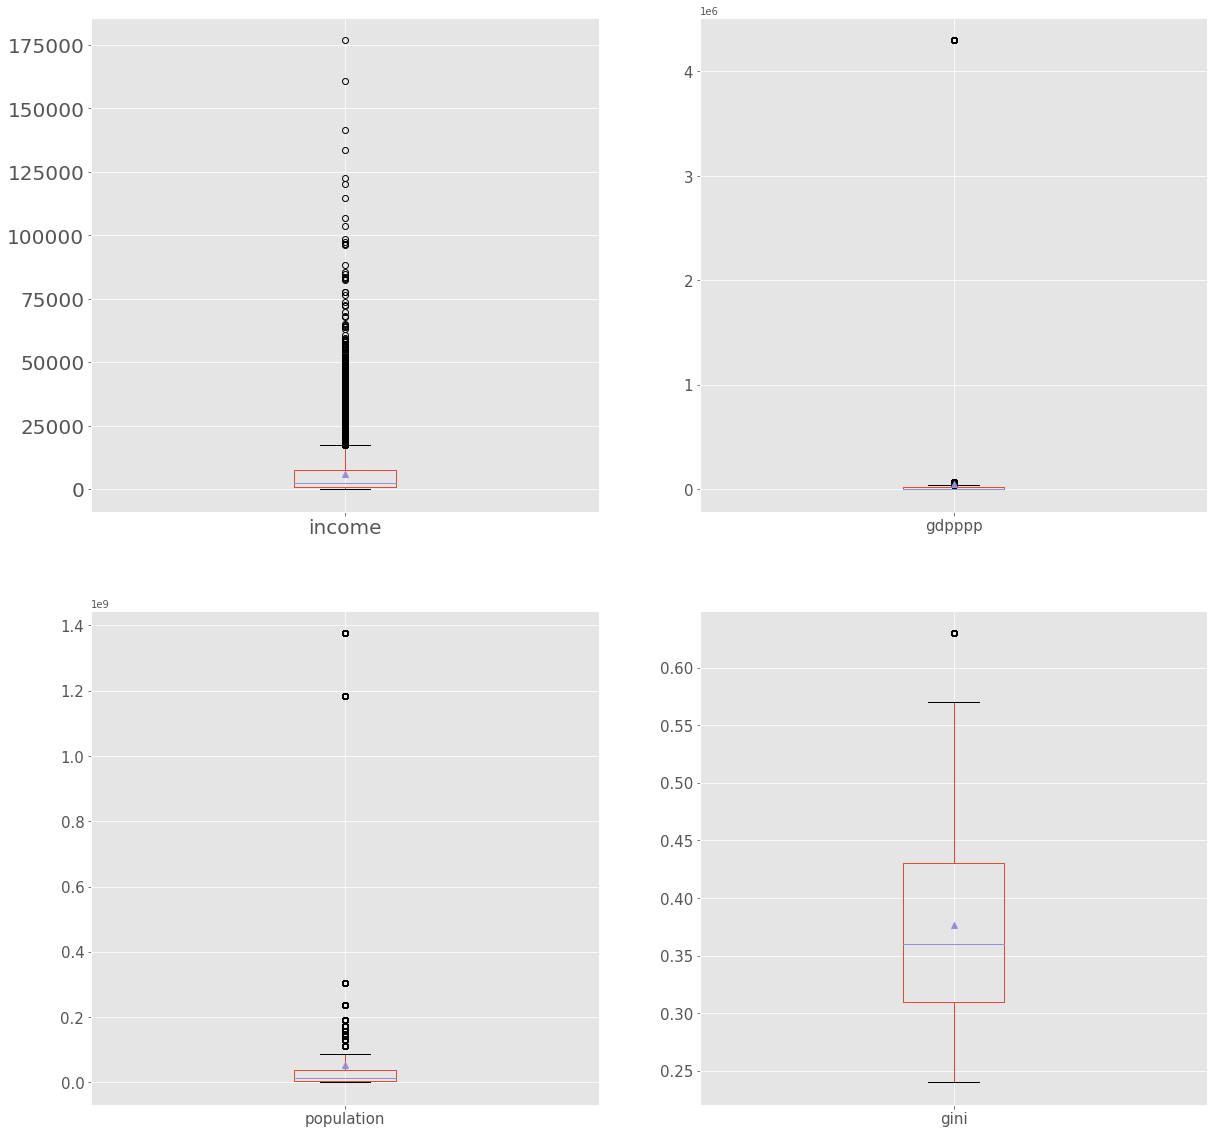

In [ ]:
#Approche visuelle par Boxplot de la distribution des variables et des éventuels outliers
plt.figure(figsize=(20, 20))

plt.subplot(221)
df.iloc[:, [5]].boxplot(fontsize=20, widths=0.2, showmeans=True)
plt.subplot(222)
df.iloc[:, [6]].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(223)
df.iloc[:, [7]].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(224)
df.iloc[:, [8]].boxplot(fontsize=15, widths=0.2, showmeans=True)

plt.savefig('variables_boxplot.jpg')
plt.show()

In [ ]:
#Identification de quelques outliers afin de vérifier que ces valeurs puissent être possibles
display(df.sort_values(by='population', ascending=False).iloc[:1, :])
display(df.sort_values(by='gdpppp', ascending=False).iloc[:1, :])
display(df.sort_values(by='gini', ascending=False).iloc[:1, :])

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
1798,CHN,China,2007,99,100,11071.51,5712.0,1.376266e+09,0.48


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
3200,FJI,Fiji,2008,1,100,308.17334,4300332.0,845361.0,0.4


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
11471,ZAF,South Africa,2008,73,100,4620.958,9602.0,49779471.0,0.63


Les outliers sont des valeurs tout à fait cohérentes avec leur pays d'affectation.

**Bilan des pays et des populations dans l'échantillon**

In [ ]:
#Identification du nombre de pays par année 
#Recherche des années les plus représentatives…
demography_group = df[['year', 'country']].drop_duplicates().groupby('year').count().reset_index()
demography_group.rename(columns={'country':'country_quantity'}, inplace=True)
demography_group

,year,country_quantity
0,2004,1
1,2006,5
2,2007,15
3,2008,76
4,2009,12
5,2010,6
6,2011,1


In [ ]:
#Intégration de la population selon les années de l'analyse
#Méthode .groupby() avec une somme des populations car nous avons une classification par quantile
pop_year = pd.DataFrame(df[df['quantile'] == 1].groupby(['year'])['population'].sum(), dtype=int).reset_index()
pop_year

,year,population
0,2004,17827825
1,2006,287548000
2,2007,2750266740
3,2008,2271976191
4,2009,475559459
5,2010,383832444
6,2011,14948801


In [ ]:
#Intégration de la population mondiale par année
#Source https://donnees.banquemondiale.org/indicateur/SP.POP.TOTL
world_population = pd.read_csv('/gdrive/MyDrive/world_population.csv', skiprows=3)
world_population = world_population[['Country Name', '2004', '2006', '2007', '2008', '2009', '2010', '2011']]
world_population = world_population[world_population['Country Name'] == 'Monde'].T.reset_index()
world_population.drop(world_population.index[0], inplace=True)
world_population.rename(columns={'index': 'year', 257: 'pop_world'}, inplace=True)

world_population = world_population.astype(int)
world_population

,year,pop_world
1,2004,6432374971
2,2006,6593623202
3,2007,6675130418
4,2008,6757887172
5,2009,6840591577
6,2010,6922947261
7,2011,7004011262


In [ ]:
#Merge des populations avec pourcentage de la part mondiale
#Recherche des années les plus représentatives…
tab = pd.merge(demography_group, pop_year, on='year')
tab = pd.merge(tab, world_population, on='year')
tab['%world_pop'] = round((tab['population']/tab['pop_world']*100), 2)
tab

,year,country_quantity,population,pop_world,%world_pop
0,2004,1,17827825,6432374971,0.28
1,2006,5,287548000,6593623202,4.36
2,2007,15,2750266740,6675130418,41.20
3,2008,76,2271976191,6757887172,33.62
4,2009,12,475559459,6840591577,6.95
5,2010,6,383832444,6922947261,5.54
6,2011,1,14948801,7004011262,0.21


2007 et 2008 sont les deux seules années représentatives de l'échantillon.

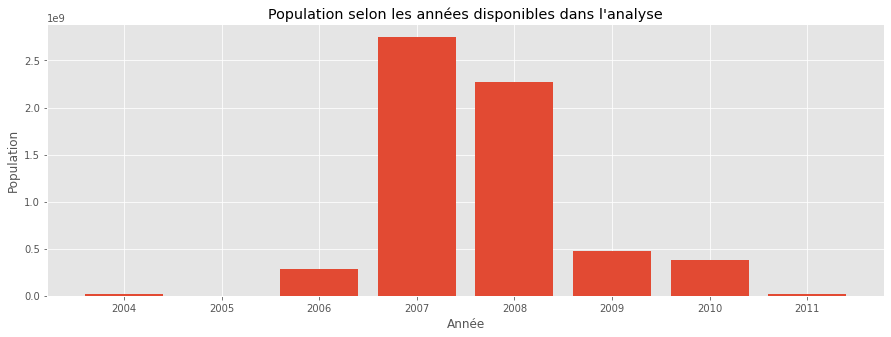

In [ ]:
#Visualisation 
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(tab['year'], tab['population'])

plt.xlabel('Année')
plt.ylabel('Population')
plt.title("Population selon les années disponibles dans l'analyse")

plt.savefig('population_diagramme.jpg')
plt.show()

**Aalyse…**

Les années pris en compte vont de 2004 à 2011 (2005 non représentée).
Une forte concentration sur les années 2007 et 2008.

116 pays sont représentés dans l'échantillon.

Les quantiles utilisés pour l'ensemble des pays, par la World Income Distribution, sont des centiles (aussi appelés percentiles ).

La méthode des centiles permet de réduire la taille de l'échantillon, tout en préservant suffisamment d'informations pour pouvoir l'analyser.

Le $PPP est une unité qui permet de comparer le pouvoir d'achat entre deux pays sans distorsion due aux taux de change.

**MISSION 2**

**Étude de la diversité des pays**

Le but est de montrer la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenu (axe des abscisses) pour 5 à 10 pays choisis pour montrer leur diversité.

Il est également nécessaire de représenter la courbe de Lorenz de chacun des pays choisis. Pour chacun de ces pays, faut aussi préciser l'évolution de l'indice de Gini au fil des ans. Les pays seront classés par indice de Gini. Enfin il faut présenter la moyenne des 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. Quelle position occupe la France ?

In [ ]:
#Rappel de l'échantillon "df" traité dans l'analyse
df.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3


In [ ]:
#Calcul du revenu moyen du pays dans lequel habite notre prospect
df_income_avg = df[['country_code','income']].groupby('country_code').mean().reset_index()
df_income_avg.rename(columns={'income':'income_avg'}, inplace=True)
df = df.merge(df_income_avg, how='left', on='country_code')
display(df.shape)
display(df.head()) 

(11600, 10)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902


Il nous faut par la suite réduire la dimension de nos données afin de faciliter l'analyse. **Le partionnement sera fait à l'aide d'un algorithme non-supervisé, le k-means.**

In [ ]:
#Clustering fait à partir d'une copie de l'échantillon, ici nommée "df_clustering"
df_clustering = df.copy()
df_clustering = df_clustering[df_clustering['country'] != 'Fiji'] 

La visualisation précédente des distributions de nos variables avait exposée quelques outliers. **Le pays Fiji sera exclu du clustering car sa valeur du gdpppp est très influente.**

In [ ]:
#Transformation en array Numpy
#Indexation selon les pays par la fonction .set_index()
df_clustering.set_index('country', inplace=True)
df_clustering.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg
country,,,,,,,,,
Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902


In [ ]:
#Par simplification (gain en temps de calcul), le clustering sera fait sur le premier quantile
#Suppression des lignes par méthode .drop_duplicates()
df_clustering.drop_duplicates(subset=['country_code'], inplace=True)
df_clustering

,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg
country,,,,,,,,,
Albania,ALB,2008,1,100,728.897950,7297.00000,3002678.0,0.30,2994.829902
Argentina,ARG,2008,1,100,254.089420,13220.00000,40080160.0,0.45,5847.884654
Armenia,ARM,2008,1,100,366.617800,5611.00000,2907618.0,0.29,1628.382785
Austria,AUT,2008,1,100,2958.076400,36193.00000,8341532.0,0.30,16637.600204
Azerbaijan,AZE,2008,1,100,397.539830,8101.00000,8821873.0,0.31,2357.429023
...,...,...,...,...,...,...,...,...,...
Vietnam,VNM,2006,1,100,234.266950,2578.00000,84617540.0,0.36,1377.773966
Occupied Palestinian Territory,PSE,2009,1,100,195.289900,3695.00000,3957670.0,0.36,1114.098514
Yemen,YEM,2008,1,100,162.951310,2224.00000,21892146.0,0.37,1042.635870


In [ ]:
#Préparation des données pour le clustering K-Means
#Ici le clustering sera établi sur les valeurs des variables 'gdpppp' et 'gini'
X = df_clustering.loc[:, ['gdpppp', 'gini']].values
Y = df_clustering.index

display(X.shape)
display(Y.shape)

(115, 2)

(115,)

Le .shape permet de **vérifier que les 116 pays (moins le pays Fiji) sont toujours dans les données à clusteriser, y compris les deux variables descriptives.**

In [ ]:
#Index des données désormais basé sur les noms des 115 pays
df_clustering.index

Index(['Albania', 'Argentina', 'Armenia', 'Austria', 'Azerbaijan', 'Belgium',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bosnia and Herzegovina',
       ...
       'Uganda', 'Ukraine', 'Uruguay', 'United States', 'Venezuela', 'Vietnam',
       'Occupied Palestinian Territory', 'Yemen', 'South Africa',
       'The Democratic Republic Of The Congo'],
      dtype='object', name='country', length=115)

In [ ]:
#Centrage / réduction des données (nécessaire pour éviter les décalages d'échelle)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

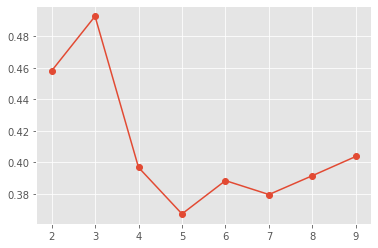

In [ ]:
#Calcul  de la métrique "silhouette" pour différents nombres de groupes issus de la méthode des centres mobiles
#Liste pour stocker nos coefficients
silhouettes = [] 

#Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 10): 
    #Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 10), silhouettes, marker='o')
plt.savefig('country_kmeans.jpg')
plt.show()

**Un k=3 est pertinent pour la réalisation du clustering **texte en gras**

In [ ]:
#Clustering K-Means en 3 clusters, introduction de notre modèle 'cls'
cls = cluster.KMeans(n_clusters=3)
cls.fit(X_scaled)

KMeans(n_clusters=3)

In [ ]:
#Tableau des Centroïdes: 3 clusters dans sa version centrée réduite
#Comparaison simplifiée, les dimensions prenant la même importance!
centroids = cls.cluster_centers_
pd.DataFrame(centroids, columns=['gdpppp', 'gini'], index=['cluster0', 'cluster1', 'cluster2'])

,gdpppp,gini
cluster0,-0.464604,1.224121
cluster1,1.597383,-0.763262
cluster2,-0.468108,-0.489378


In [ ]:
#Index trié des clusters
idk = np.argsort(cls.labels_)

#Affichage des observations selon leurs clusters
df_cls = pd.DataFrame(df_clustering.index[idk], cls.labels_[idk]).reset_index()
df_cls = df_cls.rename(columns={'index':'cluster'})

In [ ]:
#Intégration des clusters dans notre dataframe "df_cls" par la méthode .merge()
#Jointure avec le dataframe initial selon les pays et condition 'inner'
df_cls = pd.merge(df_clustering, df_cls, on='country')
df_cls.head()

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg,cluster
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.30,2994.829902,2
1,Argentina,ARG,2008,1,100,254.08942,13220.0,40080160.0,0.45,5847.884654,0
2,Armenia,ARM,2008,1,100,366.61780,5611.0,2907618.0,0.29,1628.382785,2
3,Austria,AUT,2008,1,100,2958.07640,36193.0,8341532.0,0.30,16637.600204,1
4,Azerbaijan,AZE,2008,1,100,397.53983,8101.0,8821873.0,0.31,2357.429023,2


In [ ]:
#Taille des 3 clusters, combien de pays dans chaque?
print(str(len(df_cls[df_cls['cluster'] == 0])) + " clusters dans la première partition")
print(str(len(df_cls[df_cls['cluster'] == 1])) + " clusters dans la seconde partition")
print(str(len(df_cls[df_cls['cluster'] == 2])) + " clusters dans la troisième partition")

37 clusters dans la première partition
26 clusters dans la seconde partition
52 clusters dans la troisième partition


In [ ]:
#Pays du cluster 0
print(list(df_cls[df_cls['cluster'] == 0]['country']))

['Argentina', 'Bolivia', 'Brazil', 'Central African', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Ghana', 'Guatemala', 'Honduras', 'Islamic Republic of Iran', 'Morocco', 'Madagascar', 'Mexico', 'Mozambique', 'Malawi', 'Malaysia', 'Nigeria', 'Nicaragua', 'Panama', 'Peru', 'Philippines', 'Paraguay', 'Russian Federation', 'El Salvador', 'Swaziland', 'Thailand', 'Uganda', 'Uruguay', 'Venezuela', 'South Africa', 'The Democratic Republic Of The Congo']


In [ ]:
#Pays du cluster 1
print(list(df_cls[df_cls['cluster'] == 1]['country']))

['Austria', 'Belgium', 'Canada', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Spain', 'Finland', 'France', 'United Kingdom', 'Greece', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Japan', 'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Slovakia', 'Slovenia', 'Sweden', 'Taiwan', 'United States']


In [ ]:
#Pays du cluster 2
print(list(df_cls[df_cls['cluster'] == 2]['country']))

['Albania', 'Armenia', 'Azerbaijan', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bosnia and Herzegovina', 'Belarus', 'Bhutan', 'Egypt', 'Estonia', 'Georgia', 'Guinea', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Iraq', 'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Cambodia', 'Republic of Korea', 'Kosovo', "Lao People's Democratic Republic", 'Liberia', 'Sri Lanka', 'Lithuania', 'Latvia', 'Republic of Moldova', 'The Former Yugoslav Republic of Macedonia', 'Mali', 'Montenegro', 'Mongolia', 'Mauritania', 'Niger', 'Nepal', 'Pakistan', 'Poland', 'Romania', 'Sudan', 'Serbia', 'Syrian Arab Republic', 'Tajikistan', 'Timor-Leste', 'Turkey', 'United Republic Of Tanzania', 'Ukraine', 'Vietnam', 'Occupied Palestinian Territory', 'Yemen']


Choix **des pays du cluster 1, car le gdpppp est plus important que pour les autres partitions, mais également un indice de gini très éloigné de 1 indiquant une meilleure répartition des revenus.**

In [ ]:
#Affichage des pays les plus contributeurs avec restriction selon le cluster 0
di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'country':df_clustering.index, 
                                  'country_code': df_cls['country_code'], 'cluster': df_cls['cluster'], 
                                  'gdpppp': df_cls['gdpppp'], 'gini': df_cls['gini']}).sort_values(by='c_inertie',
                                                                                                   ascending=False)
ctr_indiv_inertie[ctr_indiv_inertie['cluster'] == 1]

,c_inertie,country,country_code,cluster,gdpppp,gini
62,21.617993,Luxembourg,LUX,1,73127.0,0.33
80,9.467295,Norway,NOR,1,49070.0,0.27
108,5.649672,United States,USA,1,43261.0,0.41
25,5.135412,Denmark,DNK,1,34130.0,0.25
79,4.923471,Netherlands,NLD,1,38065.0,0.29
44,4.825163,Ireland,IRL,1,39268.0,0.31
96,4.185146,Sweden,SWE,1,34371.0,0.28
3,4.142788,Austria,AUT,1,36193.0,0.30
95,4.073487,Slovenia,SVN,1,27197.0,0.24
31,3.999579,Finland,FIN,1,33626.0,0.28


In [ ]:
nb_cluster =10

#Normalisation des données
pays_info_norm = preprocessing.scale(X)
km = cluster.KMeans(n_clusters = nb_cluster).fit(pays_info_norm)

#On determine les pays qui sont les plus proches des centroides des clusters
i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, pays_info_norm)
i_pays_plus_proches

array([2800, 6799, 3100, 3600, 9099, 7099, 5200, 8199, 3900, 1900])

**Les 10 pays ci-dessous ont été sélectionnés selon leur représentation et contribution au sein du cluster.**

In [ ]:
#Liste des pays retenus 
country_list = ['Luxembourg', 'Sweden', 'Spain', 'France', 'Crotia', 'Norway', 'United States', 'Denmark', 'Austria']
country_code = ['LUX', 'SWE', 'ESP', 'FRA', 'HRV', 'NOR', 'USA', 'DNK', 'AUT']


**Visualisation des pays en 3 graphiques**

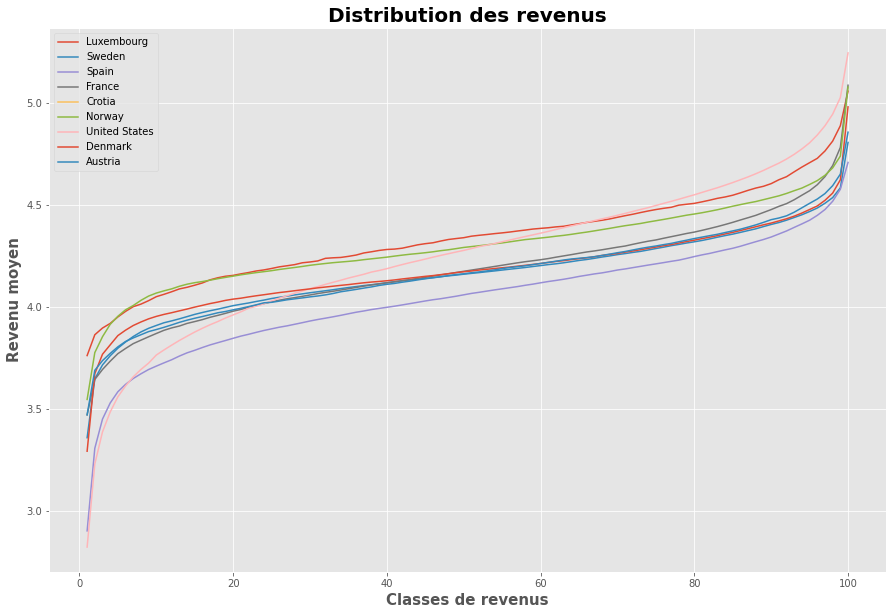

In [ ]:
#Distribution des revenus 
plt.figure(figsize=(15,10))

for x in country_list: 
    data = df[df.country == x]
    plt.plot(data['quantile'], np.log10(data['income']), label=x)

plt.title("Distribution des revenus", fontsize=20, fontweight='bold')
plt.xlabel("Classes de revenus", fontsize=15, fontweight='bold')
plt.ylabel("Revenu moyen", fontsize=15, fontweight='bold')
plt.legend()

plt.savefig('distribution_revenu_country_plot.jpg')
plt.show()

Prenons le cas des extrêmes, **l'Espagne reste toujours le pays le plus pauvre, le Luxembourg le pays le plus riche, quelque soit la classe de revenu**. 

**Pour la France on constate qu'un écart se creuse entre les classes de revenu assez faible et celles plus hautes (après le centile 50) qui positionne la population juste après les classes plus riches des pays leaders États-Unis, luxembourg et Norvège.** Ces tendances seront à vérifier plus bas avec l'évolution des indices de Gini…

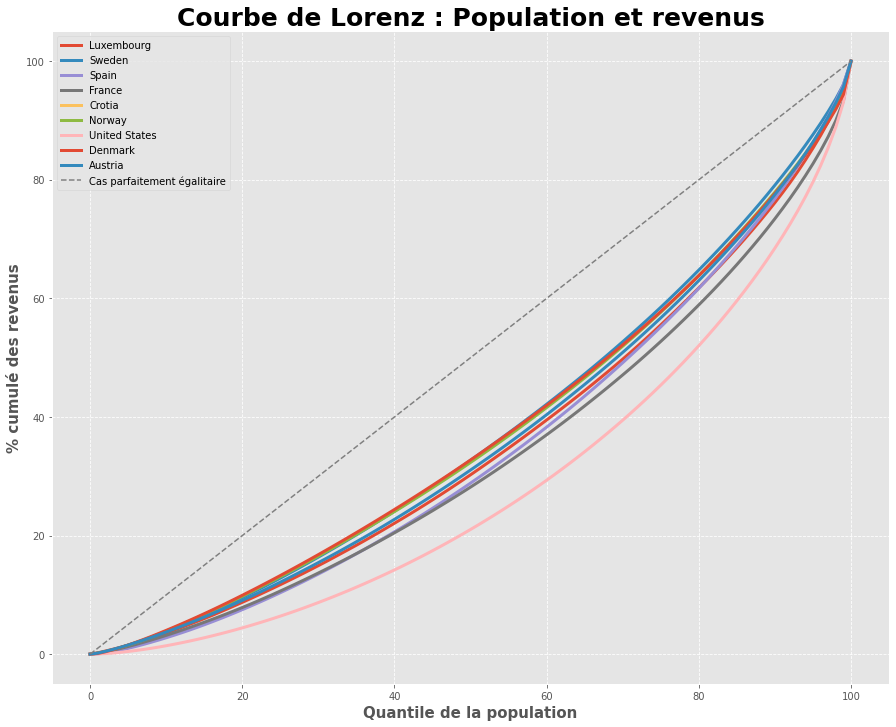

In [ ]:
#Courbe de Lorenz
plt.figure(figsize = (15, 12))
list_gini = []

for count in country_list:
    # revenus_total_pays : Revenus total sur les 100 centiles
    revenus_total_pays = df[df.country==count]['income'].sum()
    
    dep = df[df.country==count]['income'].values
    n = len(dep)
    
    # lorenz : Courbe de lorenz
    lorenz = (np.cumsum(np.sort(df[df.country==count]['income']))/revenus_total_pays)*100
    lorenz = np.append([0],lorenz) 
    x = np.append([0],df[df.country==count]['quantile'])    
    plt.plot(x,lorenz,linewidth=3, label=count)

    
plt.plot([0,100],[0,100],'grey',linestyle='--',linewidth=1.5, label='Cas parfaitement égalitaire')
plt.xlabel('Quantile de la population',fontsize=15,fontweight = 'bold')
plt.ylabel('% cumulé des revenus',fontsize=15,fontweight = 'bold')
plt.legend(loc='upper left',fontsize=10)
plt.grid(True,linestyle='--')
plt.title('Courbe de Lorenz : Population et revenus',fontsize=25,fontweight = 'bold')

plt.savefig('country_lorenz.jpg')
plt.show()

**La Suède et le Danemark présentent une distribution des revenus au sein de la population beaucoup plus égalitaire que les autres pays. A l'opposé, on peut distinguer une distribution de revenus plus inégalitaire pour les Etats-Unis et la France.**

In [ ]:
#Chargement des indices de Gini pour nos pays
#Source https://data.worldbank.org/indicator/SI.POV.GINI
gini_country = pd.read_csv('/gdrive/MyDrive/gini_worlbank.csv', skiprows=4)
gini_country.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


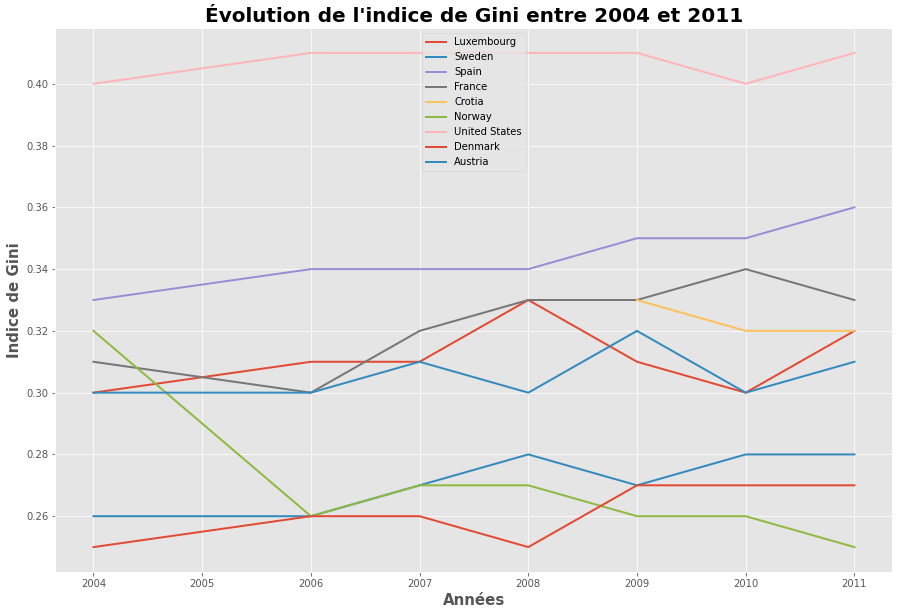

In [ ]:
#Évolution de l'indice de Gini
plt.figure(figsize=(15,10))

for c_code, c_name in zip(country_code, country_list):   
    plt.plot(gini_melt[gini_melt['country_code']==c_code]['year'],
             gini_melt[gini_melt.country_code==c_code]['gini'],linewidth=2, label=c_name)

plt.title("Évolution de l'indice de Gini entre 2004 et 2011", fontsize=20, fontweight='bold')
plt.xlabel("Années", fontsize=15, fontweight='bold')
plt.ylabel("Indice de Gini", fontsize=15, fontweight='bold')
plt.legend()

plt.savefig('gini_evolution.jpg')
plt.show()

Dans la plupart des pays **on constate un indice de Gini plus ou moins stable**, il n'y a pas de "réels changements" sur cette période. **Mais en prenant l'interprétation au cas par cas, pays par pays, on peut relever quelques points de dégradation pour la France, l'Espagne et pour la Suède. Une hausse de l'indice expliquant plus d'inégalité de revenu et de patrimoine sur cette courte période de 2004 à 2011, avec 2005 non représentée ici.**

In [ ]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque pays, dont la France
gini_group = pd.DataFrame(gini_melt.groupby(['country_code', 'country']).gini.mean()).reset_index()
gini_group['rang'] = gini_group['gini'].rank(ascending=True)
gini_group.head()

,country_code,country,gini,rang
0,AGO,Angola,0.430000,100.5
1,ALB,Albania,0.300000,20.0
2,ARG,Argentina,0.451429,113.0
3,ARM,Armenia,0.307143,23.0
4,AUS,Australia,0.343333,52.5


In [ ]:
#5 pays ayant l'indice de Gini le plus élevé
gini_group.sort_values(by='gini', ascending=False).head()

,country_code,country,gini,rang
140,ZAF,South Africa,0.63,143.0
92,NAM,Namibia,0.61,142.0
18,BWA,Botswana,0.60,141.0
29,COM,Comoros,0.56,139.5
19,CAF,Central African Republic,0.56,139.5


In [ ]:
#5 pays ayant l'indice de Gini le plus faible
gini_group.sort_values(by='gini', ascending=True).head()

,country_code,country,gini,rang
118,SVN,Slovenia,0.245714,1.0
35,DNK,Denmark,0.261429,2.0
117,SVK,Slovak Republic,0.262857,3.0
33,CZE,Czech Republic,0.265714,4.0
132,UKR,Ukraine,0.268571,5.0


In [ ]:
#Position de la France 
gini_group[gini_group.country == 'France']

,country_code,country,gini,rang
45,FRA,France,0.322857,35.5


A ce stade, **nous avons une idée plus précise du revenu moyen des pays, et de la répartition des richesses**. D'un côté des pays riches avec de fortes inégalités ou pas, et des pays comme le notre pour qui les inégalités entre les classes ont eu tendances à se creuser en quelques années. Voyons comment les classes de revenu des parents peuvent interagir au sein d'un pays, et auprès de leurs enfants.

MISSION 3

**Étude des classes de revenu des parents**

Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :

le revenu moyen du pays,
l'indice de Gini du pays.

**Il manque donc, pour un individu, la classe de revenu de ses parents**.

Ici nous supposons que l'on associe à chaque individu i une unique classe 'c_i_parent', quel que soit le nombre de parents de i.

Il est donc question de simuler cette information grâce à un coefficient (propre à chaque pays ) mesurant une corrélation entre le revenu de l'individu et le revenu de ses parents.** Ce coefficient sera ici appelé coefficient d'élasticité** pj, il mesure la mobilité intergénérationnelle du revenu.

Ci-dessous un aperçu de nos deux sources de données

In [ ]:
#Fichier elasticity.txt
elasticity_file = pd.read_csv('/gdrive/MyDrive/elasticity.txt', sep = "\t")[:16]
elasticity_file

,Coefficients of intergenerational elasticity between parents’ and
0,children’s income
1,| Base case | Optim...
2,| | (high...
3,----------------------------------------------...
4,Nordic European countries | 0.2 | ...
5,and Canada | | ...
6,----------------------------------------------...
7,Europe (except nordic | 0.4 | ...
8,countries) | | ...
9,----------------------------------------------...


In [ ]:
#Chargement et traitement des données GDIM
gdim = pd.read_csv('/gdrive/MyDrive/GDIMMay2018.csv').loc[:, ['countryname', 'iso3', 'region', 'IGEincome']]
gdim.rename(columns={'countryname': 'country', 'iso3' : 'country_code'}, inplace=True)
gdim.drop_duplicates(inplace=True)
gdim.drop_duplicates(subset=['country'], keep = 'last', inplace=True)
display(gdim.head(10))
display(gdim.shape)

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
183,Australia,AUS,High income,0.275000
243,Austria,AUT,High income,0.245267
279,Azerbaijan,AZE,Europe & Central Asia,NaN
351,Belgium,BEL,High income,0.183176
405,Benin,BEN,Sub-Saharan Africa,0.855116


(150, 4)

In [ ]:
#Isolement des pays sans valeur pour la variable 'IGEincome'
missing_gdim = gdim[gdim['IGEincome'].isna()]
display(missing_gdim.tail())
display(len(missing_gdim))

,country,country_code,region,IGEincome
6298,"Venezuela, RB",VEN,Latin America & Caribbean,NaN
6366,Vanuatu,VUT,East Asia & Pacific,NaN
6378,West Bank and Gaza,PSE,Middle East & North Africa,NaN
6390,"Yemen, Rep.",YEM,Middle East & North Africa,NaN
6492,Zambia,ZMB,Sub-Saharan Africa,NaN


77

In [ ]:
#Identification des pays sans valeur pour la variable 'IGEincome'
missing_countries_gdim = missing_gdim['country_code'].unique()
missing_countries_gdim = list(missing_countries_gdim)
len(missing_countries_gdim)

77

In [ ]:
#Visualisation des régions concernées 
list(missing_gdim.region.unique())

['South Asia',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'High income',
 'East Asia & Pacific']

In [ ]:
#Visualisation des pays concernés par la région 'High income'
missing_gdim[missing_gdim['region'] == 'High income']['country'].unique()

array(['Estonia', 'Hungary', 'Iceland', 'Israel', 'Lithuania', 'Poland',
       'Uruguay'], dtype=object)

In [ ]:
#Boucle itérative afin d'imputer les valeurs NaN sur la variable 'IGEincome'
for code in missing_countries_gdim :
    if list(gdim.loc[gdim['country_code'] == code, 'region']) == ['South Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Sub-Saharan Africa']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Latin America & Caribbean']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Europe & Central Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.40                                                               
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['East Asia & Pacific']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    else : gdim.loc[gdim['country_code'] == code, 'IGEincome'] =  0.40                                     

In [ ]:
#Jointure avec notre dataframe 'df' et celui obtenu 'gdim'
#'IGEincome' sera renommé en 'pj'
df_income_mobility = pd.merge(df, gdim[['country_code', 'IGEincome']], how='left', on='country_code')
df_income_mobility.rename(columns={'IGEincome': 'pj'}, inplace=True)
df_income_mobility.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


In [ ]:
#Vérification des éventuelles valeurs manquantes
last_list_missing_countries = list(df_income_mobility[df_income_mobility['pj'].isna()]['country'].unique())
last_list_missing_countries

['Kosovo', 'Syrian Arab Republic']

La Syrie est un pays d'Asie de l'Ouest > pj = 0.50*
*Le Kosovo est un pays d'Europe du Sud > pj = 0.40

In [ ]:
#Imputation des 2 dernières valeurs NaN dans le dataframe 
for country in last_list_missing_countries :
    if list(df_income_mobility[df_income_mobility['country'] == "Kosovo"]):
        df_income_mobility.loc[df_income_mobility['country'] == country, 'pj'] = 0.40
    else : 
        df_income_mobility.loc[df_income_mobility['country'] == country, 'pj'] = 0.50

In [ ]:
#Dernière validation de la complétude du dataframe "df_income_mobility"
df_income_mobility.isna().any()

country_code    False
country         False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
population      False
gini            False
income_avg      False
pj              False
dtype: bool

Les booléens sont tous en False, visualisons le jeu de données.

In [ ]:
#Visualisation des premières lignes de l'échantillon 
display(df_income_mobility.head())
display(df_income_mobility.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


(11600, 11)

L'échantillon contient 11600 individus, **notre échantillon de travail a désormais son coefficient d'élasticité qui mesure la mobilité intergénérationnelle du revenu. A partir des 3 variables explicatives le revenu moyen du pays, l'indice de Gini du pays et le coefficient d'élasticité**, 

nous pourrons générer des classes de revenu des parents.

**Revenus des parents selon une loi normale (de moyenne 0 et d'écart-type 1)**

Les revenus des parents (exprimés en logs) sont générés de façon aléatoires selon une loi normale. La moyenne et variance n'ont aucune incidence sur le résultat final. n doit-être supérieur à 1000 fois le nombre de quantiles.

In [ ]:
pj = 0.33                #Coefficient d'élasticité d'un pays j (ici la France sera prise pour exemple)
nb_quantiles = 100       #Nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles    #Taille de l'échantillon

In [ ]:
#Utilisation de scipy pour générer aléatoirement la variable 'ln(Yparent)'
ln_y_parent = st.norm(0,1).rvs(size=n)


**Terme d'erreur ϵ selon une loi normale (de moyenne 0 et d'écart-type Génération aléatoire d'une réalisation du terme d'erreur epsilon.**

In [ ]:
#Utilisation de scipy pour générer aléatoirement epsilon
residues = st.norm(0,1).rvs(size=n)

**Revenus des enfants ychild**

Les valeurs des revenus enfants ychild sont calculées pour une valeur donnée de pj (ici 0.33). A ce stade, ychild contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [ ]:
#Génération des revenus des parents et des enfants selon les éléments cités ci-dessus
#Application de la fonction generate_incomes()
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

y_child, y_parents = generate_incomes(n, pj)

**Calcul des classes de revenu des enfants et des parents selon les n individus générés précédemment¶**


Pour chacun des n individus générés, les classes de revenu sont calculées selon ychild et yparent.

In [ ]:
#Création d'un échantillon nommé "sample" via deux fonctions répondant aux critères liés aux quantiles
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [ ]:
#Visualisation des 5 premières classes de revenu enfants et parents
display(sample.head())
display(sample.shape)

,y_child,y_parents,c_i_child,c_i_parent
0,0.505204,0.743985,26,39
1,2.935594,0.357383,85,16
2,0.632168,1.155897,34,56
3,0.802596,3.898965,42,92
4,7.636845,1.674035,98,70


(100000, 4)

**Estimation de la distribution conditionnelle des classes de revenus parents pour chaque classe enfant¶**

Les calculs sont toujours dépendants du coefficient d'élasticité pj du pays, dans notre cas d'exemple nous sommes toujours en pj = 0.33 pour la France.

In [ ]:
#utilisation des fonctions de distribution et de probabilité conditionnelles
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]


cd = conditional_distributions(sample, nb_quantiles)


In [ ]:
#Itération selon nos classes de revenu
nb_quantiles = 101
cd = conditional_distributions(sample, nb_quantiles)

class myInformativeException(Exception):
    def __init__(self, count):
        self.count = count
proba = []
try:        
    for x, y in zip(sample['c_i_child'], sample['c_i_parent']):
        p = proba_cond(y, x, cd)
        proba.append(p)
except myInformativeException as e:
    print("Error on ", e.count)

sample['proba'] = proba
sample.head()

,y_child,y_parents,c_i_child,c_i_parent,proba
0,0.505204,0.743985,26,39,0.011
1,2.935594,0.357383,85,16,0.008
2,0.632168,1.155897,34,56,0.010
3,0.802596,3.898965,42,92,0.010
4,7.636845,1.674035,98,70,0.009


Graphiquement nous pourrons mieux comprendre la corrélation entre le revenu de l'individu et le revenu de ses parents.

**Visualisation des distributions conditionnelles**

A des fins de vérification, nous pouvons créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj: l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9).

In [ ]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_high(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Forte mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.savefig('distri_cond_forte_mobilite.jpg')
    plt.show()


**Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj :**

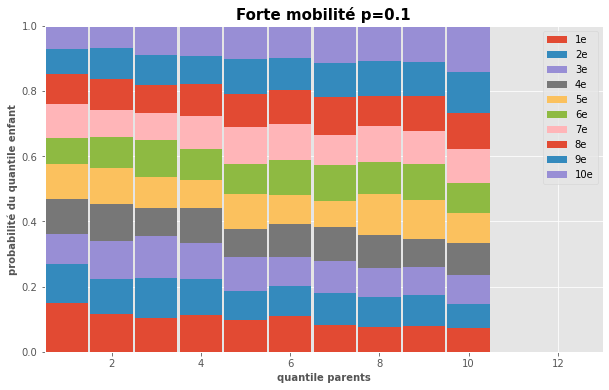

In [ ]:
#Exemple d'une forte mobilité avec un pj = 0.1
pj_strong = 0.1                
nb_quantiles_strong = 10       
n_strong  = 1000*nb_quantiles_strong   

y_child_strong, y_parents_strong = generate_incomes(n_strong, pj_strong)
sample_strong = compute_quantiles(y_child_strong, y_parents_strong, nb_quantiles_strong)
cd_strong = conditional_distributions(sample_strong, nb_quantiles_strong)
plot_conditional_distributions_high(pj_strong, cd_strong, nb_quantiles_strong)

In [ ]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_low(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Faible mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.savefig('distri_cond_faible_mobilite.jpg')
    plt.show()


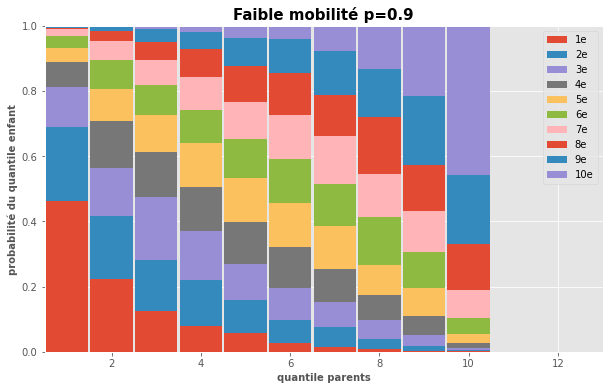

In [ ]:
#Exemple d'une très faible mobilité avec un pj = 0.9
pj_low = 0.9                
nb_quantiles_low = 10       
n_low  = 1000*nb_quantiles_low   

y_child_low, y_parents_low = generate_incomes(n_low, pj_low)
sample_low = compute_quantiles(y_child_low, y_parents_low, nb_quantiles_low)
cd_low = conditional_distributions(sample_low, nb_quantiles_low)
plot_conditional_distributions_low(pj_low, cd_low, nb_quantiles_low)

**Les deux exemples démontrent clairement des situations extrêmes révélatrices de la mobilité des classes de revenu enfants / parents**. 

Dans une situation à faible mobilité intergénérationnelle, prenons l'exemple de la 10ème classe parents pour laquelle il y a moins de 50% de mobilité chez les enfants, en d'autres termes les enfants resteront majoritairement dans la classe de revenu de leurs parents.

**Suppression des individus**

Pour éviter toute confusion, les individus générés sont supprimés (car inutiles pour la suite), seules les distributions conditionnelles sont conservées.

In [ ]:
sample = sample.iloc[:, 2:]
sample.head()

,c_i_child,c_i_parent,proba
0,26,39,0.011
1,85,16,0.008
2,34,56,0.010
3,42,92,0.010
4,98,70,0.009


**Nouvel échantillon : 500 fois plus grand que celui de la World Income Distribution**

Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, il y aura 499 "clones". **La taille du nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.**

In [ ]:
#Cet échantillon sera nommé "df_wid500", clone représentatif des individus de la WID
df_wid500 = df_income_mobility[['country_code', 'country', 'quantile', 'population', 
                                'income', 'income_avg', 'gini', 'pj']]

df_wid500 = pd.concat([df_wid500]*500, ignore_index=True)
display(df_wid500.head())
display(df_wid500.shape)

,country_code,country,quantile,population,income,income_avg,gini,pj
0,ALB,Albania,1,3002678.0,728.89795,2994.829902,0.3,0.815874
1,ALB,Albania,2,3002678.0,916.66235,2994.829902,0.3,0.815874
2,ALB,Albania,3,3002678.0,1010.91600,2994.829902,0.3,0.815874
3,ALB,Albania,4,3002678.0,1086.90780,2994.829902,0.3,0.815874
4,ALB,Albania,5,3002678.0,1132.69970,2994.829902,0.3,0.815874


(5800000, 8)

Attribution des classes parents aux 500 individus de chaque pays
Pour chaque  𝑐𝑖,𝑐ℎ𝑖𝑙𝑑  et chaque pays, il y a donc 500 individus. 

 Maintenant il est question d'attribuer aux 500 individus leurs classes  𝑐𝑖,𝑝𝑎𝑟𝑒𝑛𝑡  conformément aux distributions trouvées précédemment. Par exemple, si P( 𝑐𝑖,𝑝𝑎𝑟𝑒𝑛𝑡 =8| 𝑐𝑖,𝑐ℎ𝑖𝑙𝑑 =5, 𝑝𝑗 =0.9) = 0.03 , alors la classe  𝑐𝑖,𝑝𝑎𝑟𝑒𝑛𝑡  sera 8 à 15 des 500 individus du pays j ayant  𝑐𝑖,𝑐ℎ𝑖𝑙𝑑 =5 , car 500*0.03 = 15.

In [ ]:
#Coefficient d'élasticité / code pays
country_income = df_income_mobility[['country_code', 'pj']]
country_income

,country_code,pj
0,ALB,0.815874
1,ALB,0.815874
2,ALB,0.815874
3,ALB,0.815874
4,ALB,0.815874
...,...,...
11595,COD,0.707703
11596,COD,0.707703
11597,COD,0.707703
11598,COD,0.707703


In [ ]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n = len(df_wid500) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)


In [ ]:
df_wid500 = pd.concat([
   pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']),
   df_wid500], axis=1)
df_wid500


,ln_y_parent,residus,country_code,country,quantile,population,income,income_avg,gini,pj
0,0.433980,-1.778073,ALB,Albania,1,3002678.0,728.89795,2994.829902,0.30,0.815874
1,-0.936572,0.358816,ALB,Albania,2,3002678.0,916.66235,2994.829902,0.30,0.815874
2,0.594741,0.148855,ALB,Albania,3,3002678.0,1010.91600,2994.829902,0.30,0.815874
3,-0.770170,0.312035,ALB,Albania,4,3002678.0,1086.90780,2994.829902,0.30,0.815874
4,0.024164,1.833999,ALB,Albania,5,3002678.0,1132.69970,2994.829902,0.30,0.815874
...,...,...,...,...,...,...,...,...,...,...
5799995,0.933510,-0.669294,COD,The Democratic Republic Of The Congo,97,4011486.0,911.78340,276.016044,0.44,0.707703
5799996,0.439503,0.902460,COD,The Democratic Republic Of The Congo,98,4011486.0,1057.80740,276.016044,0.44,0.707703
5799997,1.661457,-1.495121,COD,The Democratic Republic Of The Congo,99,4011486.0,1286.60290,276.016044,0.44,0.707703
5799998,-0.580475,-0.013190,COD,The Democratic Republic Of The Congo,100,4011486.0,2243.12260,276.016044,0.44,0.707703


**Modélisation : étude de l'ANOVA**

Ici il sera question d'expliquer le revenu des individus en fonction de plusieurs variables explicatives : **le pays de l'individu, l'indice de Gini de ce pays, la classe de revenu des parents**, etc. L'analyse de la Variance permettra d'expliquer l'influence de notre variable explicative, le pays de l'individu. Puis pour finir la performance du modèle sera étudiée

In [ ]:
from scipy.stats import t, shapiro
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import t, shapiro

In [ ]:
#Rappel de l'échantillon final précédemment obtenu
display(df_wid500.head())
display(df_wid500.shape)

,ln_y_parent,residus,country_code,country,quantile,population,income,income_avg,gini,pj
0,0.433980,-1.778073,ALB,Albania,1,3002678.0,728.89795,2994.829902,0.3,0.815874
1,-0.936572,0.358816,ALB,Albania,2,3002678.0,916.66235,2994.829902,0.3,0.815874
2,0.594741,0.148855,ALB,Albania,3,3002678.0,1010.91600,2994.829902,0.3,0.815874
3,-0.770170,0.312035,ALB,Albania,4,3002678.0,1086.90780,2994.829902,0.3,0.815874
4,0.024164,1.833999,ALB,Albania,5,3002678.0,1132.69970,2994.829902,0.3,0.815874


(5800000, 10)

**ANOVA à un facteur variable explicative le pays de l’individu**

Réalisation de l'ANOVA en considérant ** comme variable explicative que le pays de l’individu, puis analyse de la performance du modèle.**
Utilisation de statsmodels

**On dispose de plusieurs variables quantitatives et d'une seule qualitative : le pays (on exclue la région)**. 

**On testera au préalable si le pays a un impact sur le revenu d'un individu, avec une ANOVA.**

L'ANOVA compare les moyennes entre plus de 2 groupes (ici, les pays). On cherchera à rejeter l'hypothèse 0, selon laquelle les moyennes (ici, de revenus enfants) ne varient pas entre pays.

Si les moyennes de revenu diffèrent entre les groupes, on pourra dire que le pays est corrélé au revenu des enfants

**Première approche par représentation visuelle Boxplot selon les 9 pays identifiés lors du clustering**

Il est intéressant d'avoir un premier aperçu **pouvant montrer l'influence d'un pays sur le revenu moyen des individus.**

In [ ]:
#Rappel des pays identifiés lors du clustering et restriction sur notre échantillon "df_wid500"
country_list =['Luxembourg', 'Sweden', 'Spain', 'France', 'Crotia', 'Norway', 'United States', 'Denmark', 'Austria']
df_wid500_country_list = df_wid500[df_wid500['country'].isin(country_list)]

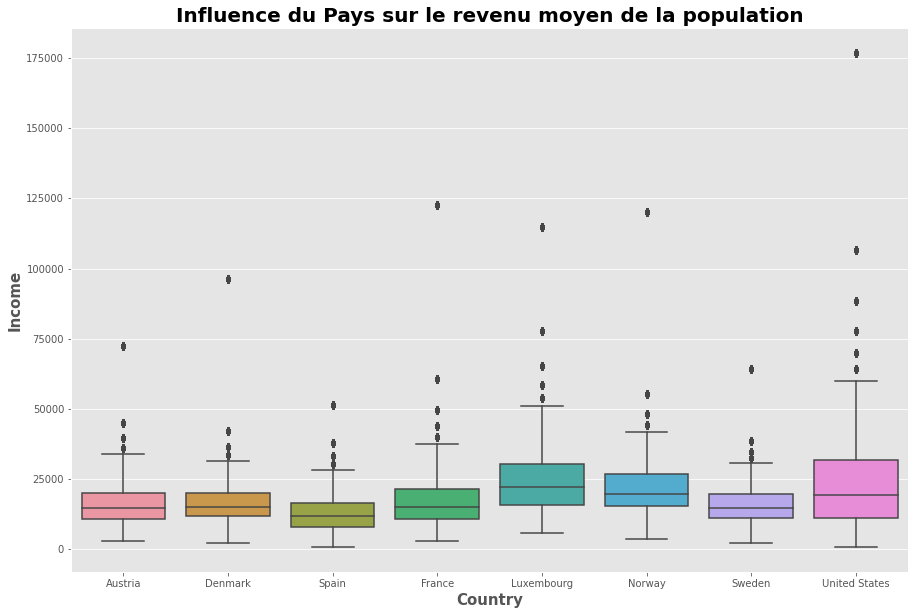

In [ ]:
#Représentation des distributions par boxplot 
plt.figure(figsize=(15, 10))

ax = sns.boxplot(x="country", y="income", data=df_wid500_country_list)
plt.title('Influence du Pays sur le revenu moyen de la population', fontsize=20, fontweight='bold')
plt.xlabel('Country', fontsize=15, fontweight='bold')
plt.ylabel('Income', fontsize=15, fontweight='bold')

plt.savefig('distribution_income_country_selection.jpg')
plt.show()

Les pays semblent assez différentes, l'ordre de grandeur de ces écarts n'est pas très grand. **La question sera de savoir si ces écarts sont significatifs ou pas. C'est l'ANOVA qui nous permettra de répondre à cette question.**

In [ ]:
#Anova pour tester l'influence du pays de l’individu sur le revenu moyen des individus 
anova_income = smf.ols('income ~ country_code', data=df_wid500).fit()
print(anova_income.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 4.971e+04
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:26:18   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799884   BIC:                         1.186e+08
Df Model:                         115                                         
Covariance Type:            nonrobust                                         


**R² = 0.496, on peut en conclure que la variable explicative Pays explique près de 50%** de la variance du revenu de l'individu. Le reste, donc la moitié de la variance sur le revenu est expliquée par les autres facteurs non considérés dans ce modèle.

**Test de Fisher**

In [ ]:
#Affichage des resultats du test de Fisher (influence de la variable pays)
import statsmodels.api as sm
sm.stats.anova_lm(anova_income, typ=2)

,sum_sq,df,F,PR(>F)
country_code,2.551188e+14,115.0,49710.75889,0.0
Residual,2.588293e+14,5799884.0,NaN,NaN


**La p-valeur de ce test (~0.0)** est très petite et largement inférieure à 5%. On rejette donc l'hypothèse H0 selon laquelle . Le pays a donc bien une influence sur le revenu moyen des individus, comme nous en avions l'intuition en regardant les boxplot…

Comparaison de l'ANOVA avec le logarithme du revenu de l'individu :

Le modèle sera t-il plus performant? Le but ici est de pouvoir déterminer l'impact du logarithme sur l'ANOVA 

In [ ]:
#Calcul et intégration de la variable logarithmique 'ln_income'
df_wid500['ln_income'] = np.log(df_wid500['income'])

In [ ]:
#Nouvelle Anova pour tester l'influence du pays de l’individu sur le logarithme du revenu moyen des individus 
anova_ln_income = smf.ols('ln_income ~ country_code', data=df_wid500).fit()
print(anova_ln_income.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 1.358e+05
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:27:56   Log-Likelihood:            -6.3135e+06
No. Observations:             5800000   AIC:                         1.263e+07
Df Residuals:                 5799884   BIC:                         1.263e+07
Df Model:                         115                                         
Covariance Type:            nonrobust                                         


**En considérant le logarithme du revenu, la variance expliquée est plus concluante, 73% contre 50% précédemment.**

**Regression Linéaire**

**Régression linéaire sur nos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu.** Quel est le pourcentage de variance expliquée par le(s) modèle(s) ?

**Première Régression Linéaire : Revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu**

In [ ]:
#Création du premier modèle de Régression linéaire
modele1 = smf.ols('income ~ gini + income_avg', data=df_wid500).fit()
print(modele1.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.858e+06
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:27:59   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799997   BIC:                         1.186e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.48e-12     14.971   1.66e-13      1.0

la variance des résidus est beaucoup moins élévée qu'avec le modèle précédent
la variable gini n'est plus significative (p-value de 1)
income_mean explique à elle seule le modèle (p-value de 0)
la colinéarité est beaucoup plus forte que précédemment (le modèle renvoie d'ailleurs un avertissement cette fois-ci)
le coefficient de la seule variable significative (income_mean) passe à 1 : pas besoin de multiplier sa valeur vu qu'elle est la seule avec l'intercept dans la formule de régression.

**Ce modèle n'explique que 50% de la variance, nous ne sommes pas plus performant que l'ANOVA.**

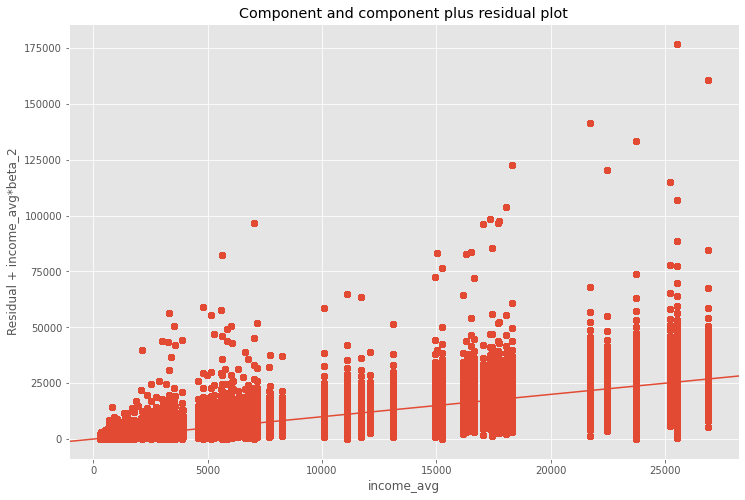

In [ ]:
#Approche visuelle rapide de notre régression linéaire
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(modele1, "income_avg", ax=ax)

**Comparer la performance du premier modèle avec un second modèle incluant le logarithme du revenu moyen du pays.**

**Seconde Régression Linéaire : Logarithme du Revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu**

In [ ]:
#Calcul et intégration de la variable logarithmique 'ln_income_avg'
df_wid500['ln_income_avg'] = np.log(df_wid500['income_avg'])

In [ ]:
#Création d'un second modèle de Régression linéaire à des fins de comparaison selon le logarithme 
modele2 = smf.ols('ln_income ~ gini + ln_income_avg', data=df_wid500).fit()
print(modele2.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 7.773e+06
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:28:22   Log-Likelihood:            -6.3237e+06
No. Observations:             5800000   AIC:                         1.265e+07
Df Residuals:                 5799997   BIC:                         1.265e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4732      0.003    162.862

Ici, avec les variables au logarithme on constate que :

le modèle explique 72% de la variance
les 2 variables contribuent toutes deux au modèle, avec un P>|t| à 0
le coefficient de significativité du revenu moyen est positif, tandis que celui du Gini est négatif. Plus l'indice de Gini sera haut (signe d'inégalité), plus le revenu prédit sera faible.

Table d'analyse des variances avec statsmodels

In [ ]:
anova_table_gini_ln = sm.stats.anova_lm(modele2, typ=2)
anova_table_gini_ln["eta_sq"] = anova_table_gini_ln[:-1]['sum_sq']/sum(anova_table_gini_ln['sum_sq'])
anova_table_gini_ln

,sum_sq,df,F,PR(>F),eta_sq
gini,1.094000e+05,1.0,2.110927e+05,0.0,0.010790
ln_income_avg,7.023332e+06,1.0,1.355187e+07,0.0,0.692731
Residual,3.005882e+06,5799997.0,NaN,NaN,NaN


In [ ]:
#Autre méthode de calcul de la variance expliquée du modèle
var_exp_model = round((modele2.ess / modele2.centered_tss)*100,2)
var_exp_model

72.83

**Décomposition de la variance**

In [ ]:
var_exp_pays = round(sum(anova_table_gini_ln[0:3]["eta_sq"])*100,2)
print("Le pourcentage de la variance expliquée par le pays de naissance est donc de :",var_exp_pays,"%")

Le pourcentage de la variance expliquée par le pays de naissance est donc de : 70.35 %


In [ ]:
var_exp_autres = round(var_exp_model - var_exp_pays,2)
print("Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de :",var_exp_autres,"%")

Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de : 2.48 %


In [ ]:
#Variance totale SCT
modele2.centered_tss

11062516.88613736

In [ ]:
#Variance expliquée SCE
modele2.ess

8056635.2064939495

In [ ]:
#Variance résiduelle SCR
modele2.ssr

3005881.679643411

**Comme lors de l'étude de l'ANOVA, la version logarithmique est plus perfomante. Il ressort que le modèle 2, en prenant donc le logarithme du revenu et le logarithme du revenu moyen, la performance est plus optimale. Les p-valeurs sont d'ailleurs très faibles.**

**Nous retrouvons le même niveau de performance que dans l'ANOVA du logarithme du revenu. Le modèle 2 peut expliquer 73% de la variance, le restant peut s'expliquer sur d'autres critères non pris en compte jusqu'ici, à savoir les classes de revenu des parents, ou encore des critères sociaux professionels, etc…**

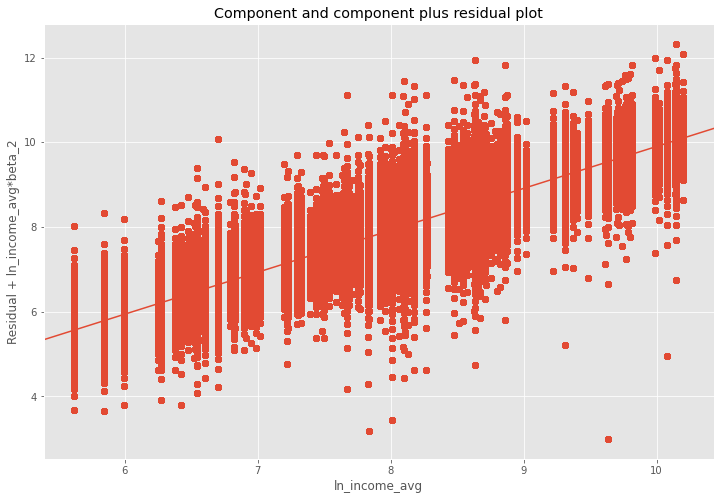

In [ ]:
#Approche visuelle rapide de notre régression linéaire (cette fois-ci bien plus optimale)
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(modele2, "ln_income_avg", ax=ax)

**La seconde approche visuelle de la régression linéaire est également plus représentatrice.**

**Comparaison des régressions linéaires en utilisant Scikit-Learn :**

In [ ]:
#Premier modèle (sans logarithme)
from sklearn import linear_model
X = df_wid500[['income_avg', 'gini']]
y = df_wid500['income']

model1 = linear_model.LinearRegression().fit(X, y)
model1.score(X, y)

0.4963901423109962

In [ ]:
#Second modèle (avec logarithme)
from sklearn import linear_model
X = df_wid500[['ln_income_avg', 'gini']]
y = df_wid500['ln_income']

model2 = linear_model.LinearRegression().fit(X, y)
model2.score(X, y)

0.7282822968243203

Cette comparaison rapide permet de conforter les précédents résultats, **les modèles sont plus performants avec logarithme, ainsi la variance expliquée permet de comprendre près de 73% le revenu des individus.**


**Diagnostic de la régression linéaire des deux modèles (sans et avec logarithme)**

**Normalité des résidus **




**L’inférence dans la régression linéaire multiple repose sur l’hypothèse de normalité des erreurs. Une première vérification importante consiste à vérifier la compatibilité des résidus (l’erreur observée sur l’échantillon).**

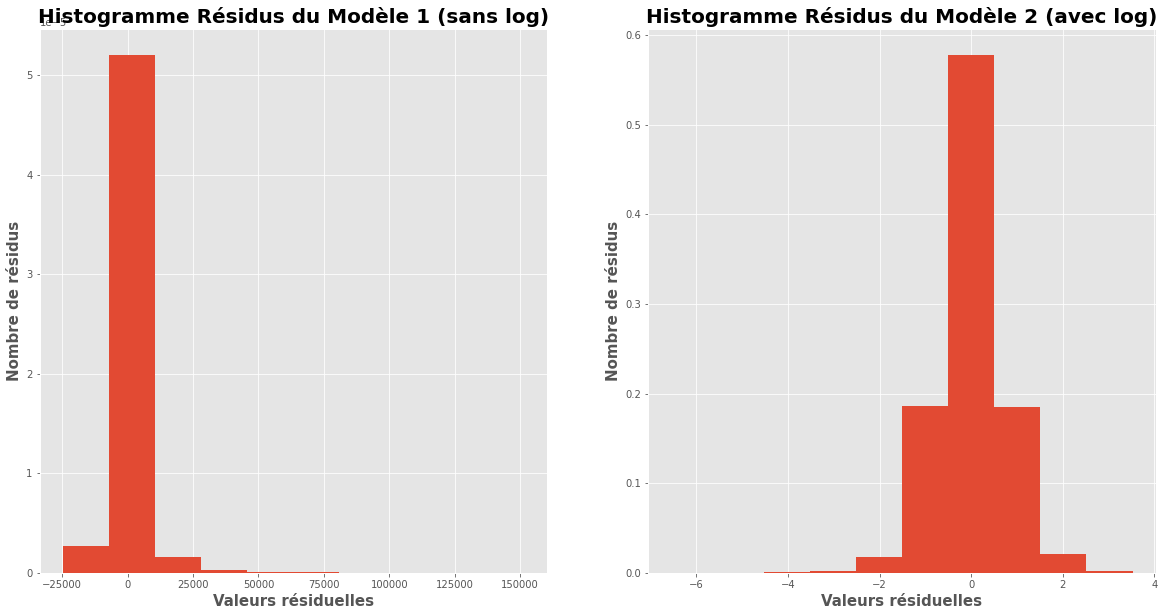

In [ ]:
#Visualisation de la normalité des résidus : 
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.hist(modele1.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle 1 (sans log)', fontsize=20, fontweight='bold')

plt.subplot(122)
plt.hist(modele2.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle 2 (avec log)', fontsize=20, fontweight='bold')

plt.savefig('residus_distribution_model1_model2.jpg')
plt.show()

**Le modèle 1 (sans logarithme) renvoie une distribution des résidus qui semble suivre plus difficilement une loi normale, tandis que le second modèle propose une distribution plus gaussienne, plus homogène.**

**Autre visualisation de la distribution des résidus :**

**Le graphique qqplot permet de vérifier la compatibilité de deux distributions. Dans notre cas, nous confrontons la distribution empirique des résidus avec la distribution théorique de la loi normale. **

**On parle aussi de Droite de Henry. L’hypothèse nulle (normalité) est rejetée si la série de points s’écarte manifestement de la diagonale.**

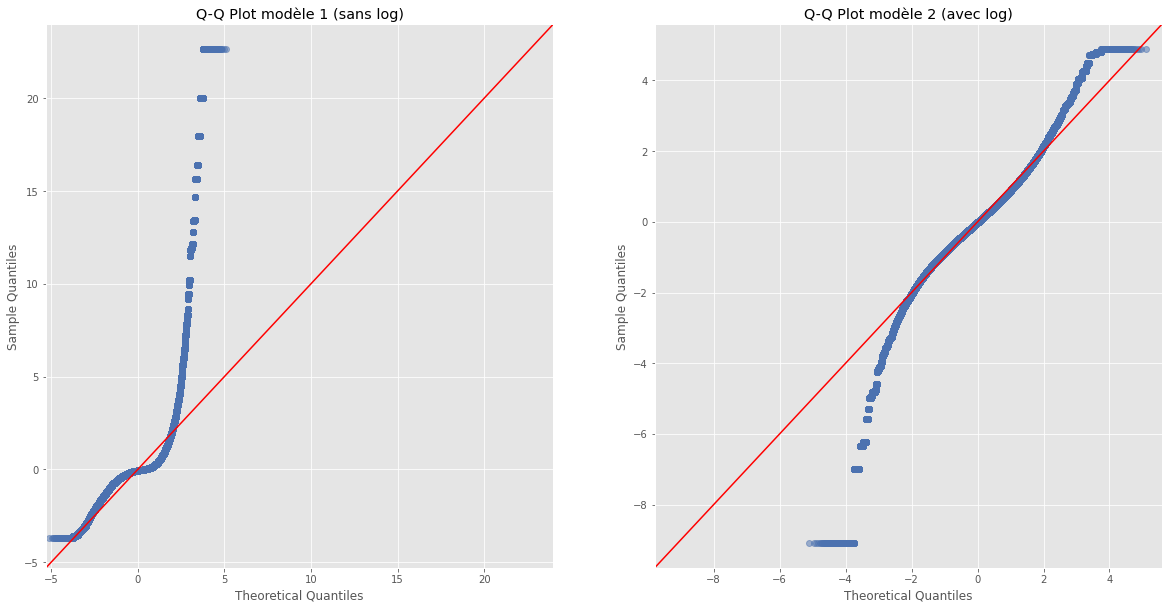

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

model_norm_residuals1 = modele1.get_influence().resid_studentized_internal
model_norm_residuals2 = modele2.get_influence().resid_studentized_internal

QQ1 = ProbPlot(model_norm_residuals1)
QQ2 = ProbPlot(model_norm_residuals2)

QQ1.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])
QQ2.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[1])
ax[0].set_title('Q-Q Plot modèle 1 (sans log)')
ax[1].set_title('Q-Q Plot modèle 2 (avec log)')
                
plt.savefig('qqplot_model1_model2.jpg')
plt.show()


**Le Q-Q plot vient confirmer que le modèle 2 issu des logarithmes propose une distribution des résidus plus alignée avec la distribution théorique d'une loi normale.**

**Test d'adéquation à une loi normale : la statistique de Kolmogorov-Smirnov**


On peut se douter que la distribution de nos résidus n'est pas "parfaite".

 Vérifions-le par les chiffres. 
 
 L'échantillon étant de forte volumétrie, le test se fera selon Kolmogorov-Smirnov et non Shapiro-Wilk.

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
#Modèle 1 non logarithmique
X_ln2 = modele1.resid
Xbar_ln2 = np.mean(X_ln2)
Xsprime_ln2 = np.std(X_ln2)

ks_2samp(modele1.resid, list(np.random.normal(Xbar_ln2, Xsprime_ln2, 5_800_000)))

Ks_2sampResult(statistic=0.24622741379310342, pvalue=0.0)

In [ ]:
#Modèle 2 logarithmique
X_ln2 = modele2.resid
Xbar_ln2 = np.mean(X_ln2)
Xsprime_ln2 = np.std(X_ln2)

ks_2samp(modele2.resid, list(np.random.normal(Xbar_ln2, Xsprime_ln2, 5_800_000)))

Ks_2sampResult(statistic=0.034997241379310345, pvalue=0.0)

**Ici, l'hypothèse de normalité est remise en cause (p-value = 0.0 < 0.05).**

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille très importante, permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant parfaitement gaussien.

**Test de colinéarité de nos deux modèles**


Vérification d'une éventuelle colinéarité approchée des variables.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#Modèle 1 non logarithmique
variables = modele1.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.1169772875434922, 1.1169772875434976]

In [ ]:
#Modèle 2 logarithmique
variables = modele2.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]


[1.0649100485551606, 1.0649100485551708]

La documentation de Statsmodels nous indique que si le VIF est supérieur à 5, alors la variable explicative donnée est hautement colinéaire avec les autres variables explicatives. Cela pourrait apporter des erreurs importantes à notre modèle.



Aucun problème de colinéarité, en effet nos coefficients **sont inférieurs à 10 et même à 5.**

Test d’homoscédasticite (constance des variables ) par Breusch-Pagan


Ce test consiste **à vérifier la constance de la variation des résidus. En cas d'hétéroscédasticité, la variance de l'erreur n'est pas constante. Dans le cas contraire, (hypothèse d'homoscédasticité) la variance de l'erreur est constante**

H0: L'homoscédasticité est présente ( les résidus sont distribués avec une variance égale)
H1: L'hétéroscédasticité est présente ( les résidus ne sont pas distribués avec une variance égale)

si p est>0,05 nous rejetons HO et validons H1

In [ ]:
__, pval, __, f_pval = sms.het_breuschpagan(modele1.resid, modele1.model.exog)
print('Modèle 1 p value test Breusch-Pagan:', pval)

__, pval, __, f_pval = sms.het_breuschpagan(modele2.resid, modele2.model.exog)
print('Modèle 2 p value test Breusch-Pagan:', pval)

Modèle 1 p value test Breusch-Pagan: 0.0
Modèle 2 p value test Breusch-Pagan: 0.0


**H0: Homoscédasticité et H1: Hétéroscédasticité**

**Rejet de l'hypothèse H0, il y a hétéroscédasticité des residus.**

Etant donné que nous travaillons sur un échantillon contenant 5,8 Millions d'observations, le modèle de régression linéaire multiple reste robuste. De ce fait, il peut supporter des écarts importants aux hypothèses gaussiennes et homoscédastiques.

Détection des points atypiques et influents
Les deux précédents modèles, issus du résultat de la régression, seront utilisés pour analyser les points influents.
Les tests seront fait à un niveau % ( commentaire à completer ) **texte en gras**
 sera le nombre d'individus de l'échantillon, et , le nombre de variables :

In [ ]:
alpha = .05
n = len(df_wid500)
p = 3

In [ ]:
#Création d'un dataframe spécifique à l'analyse des modèles
analyse = df_wid500.copy()
analyse.head()

,ln_y_parent,residus,country_code,country,quantile,population,income,income_avg,gini,pj,ln_income,ln_income_avg
0,0.433980,-1.778073,ALB,Albania,1,3002678.0,728.89795,2994.829902,0.3,0.815874,6.591534,8.004643
1,-0.936572,0.358816,ALB,Albania,2,3002678.0,916.66235,2994.829902,0.3,0.815874,6.820739,8.004643
2,0.594741,0.148855,ALB,Albania,3,3002678.0,1010.91600,2994.829902,0.3,0.815874,6.918612,8.004643
3,-0.770170,0.312035,ALB,Albania,4,3002678.0,1086.90780,2994.829902,0.3,0.815874,6.991092,8.004643
4,0.024164,1.833999,ALB,Albania,5,3002678.0,1132.69970,2994.829902,0.3,0.815874,7.032359,8.004643


**Analyse des leviers avec seuil **:
.
Il est important d'identifier les observations qui peuvent fausser les résultats de la régression.



In [ ]:
seuil_levier = 2*p/n

In [ ]:
#Intégration de deux variables spécifiques à chacun des modèles
analyse['levier_modele1'] = modele1.get_influence().hat_matrix_diag
analyse['levier_modele2'] = modele2.get_influence().hat_matrix_diag

In [ ]:
#Agrégation des données selon leurs pays, vision simplifiée du couple pays/levier
#Simplification du dataframe pour une visualisation et interprétation plus rapide
analyse_levier = analyse.groupby('country')[['country', 'levier_modele1', 'levier_modele2']].mean().reset_index()
analyse_levier.head()

,country,levier_modele1,levier_modele2
0,Albania,4.420352e-07,3.469521e-07
1,Argentina,3.248942e-07,4.061480e-07
2,Armenia,5.696309e-07,5.146475e-07
3,Austria,6.463686e-07,5.793309e-07
4,Azerbaijan,4.216152e-07,3.362739e-07


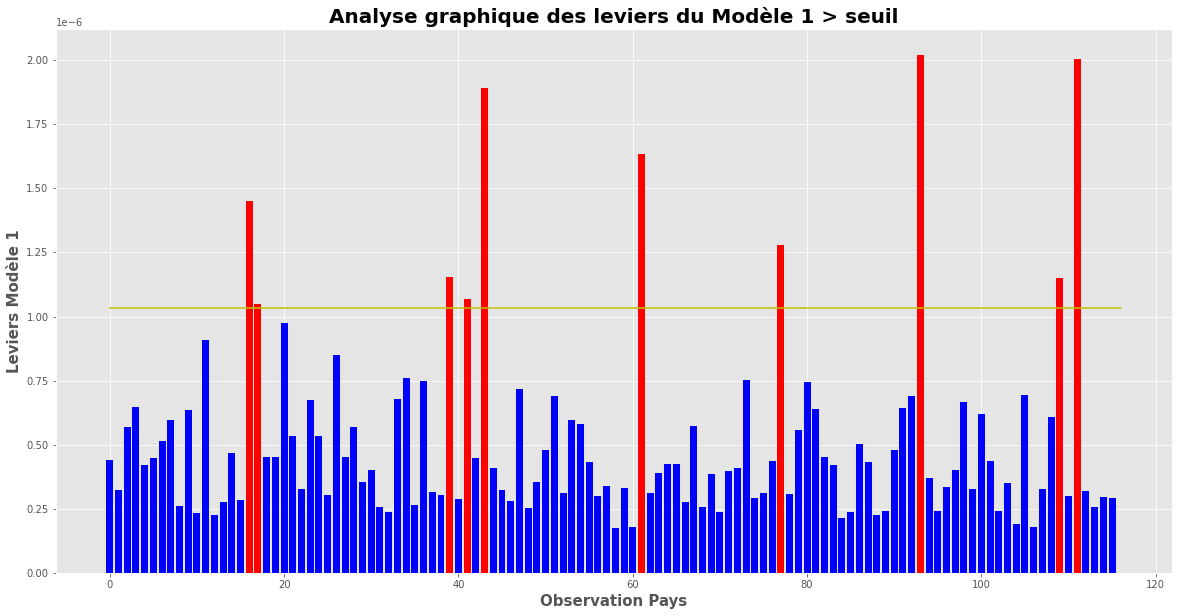

In [ ]:
#Visualisation des leviers du Modèle 1 par pays avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(analyse_levier.loc[analyse_levier['levier_modele1'] <= seuil_levier]['country'].index,
        analyse_levier.loc[analyse_levier['levier_modele1'] <= seuil_levier]['levier_modele1'], color='b')
plt.bar(analyse_levier.loc[analyse_levier['levier_modele1'] > seuil_levier]['country'].index,
        analyse_levier.loc[analyse_levier['levier_modele1'] > seuil_levier]['levier_modele1'], color='r')
plt.plot([0, 116], [seuil_levier, seuil_levier], color='y')

plt.xlabel('Observation Pays', fontsize=15, fontweight='bold')
plt.ylabel('Leviers Modèle 1', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des leviers du Modèle 1 > seuil', fontsize=20, fontweight='bold')

plt.savefig('levier_model1.jpg')
plt.show()

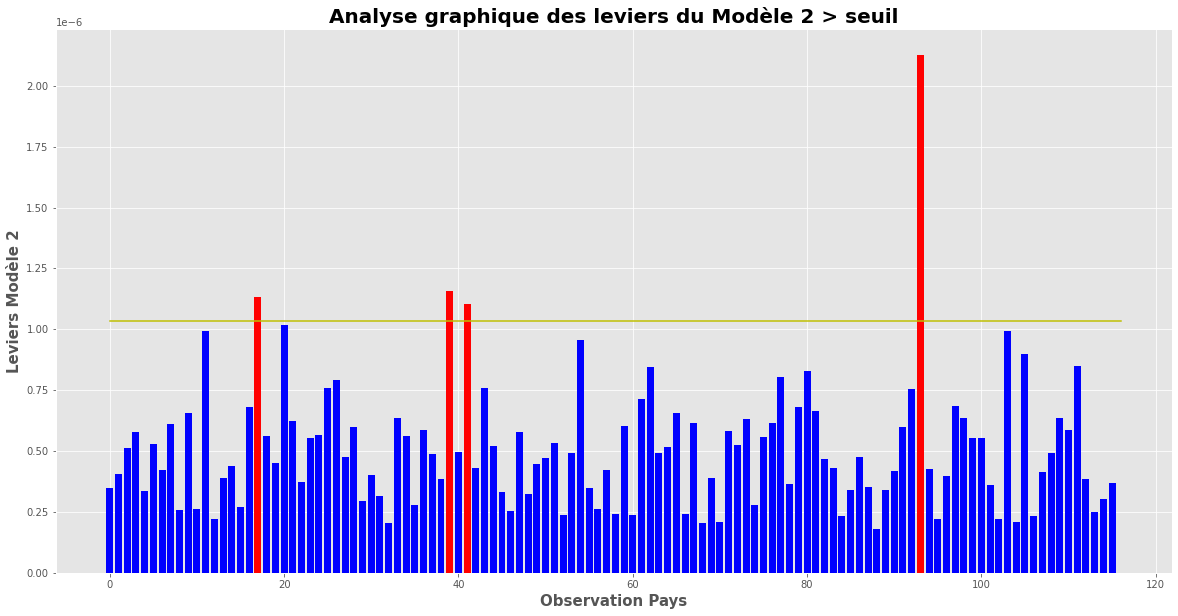

In [ ]:
#Visualisation des leviers du Modèle 2 par pays avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(analyse_levier.loc[analyse_levier['levier_modele2'] <= seuil_levier]['country'].index,
        analyse_levier.loc[analyse_levier['levier_modele2'] <= seuil_levier]['levier_modele2'], color='b')
plt.bar(analyse_levier.loc[analyse_levier['levier_modele2'] > seuil_levier]['country'].index,
        analyse_levier.loc[analyse_levier['levier_modele2'] > seuil_levier]['levier_modele2'], color='r')
plt.plot([0, 116], [seuil_levier, seuil_levier], color='y')

plt.xlabel('Observation Pays', fontsize=15, fontweight='bold')
plt.ylabel('Leviers Modèle 2', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des leviers du Modèle 2 > seuil', fontsize=20, fontweight='bold')

plt.savefig('levier_model2.jpg')
plt.show()


Il faut pouvoir jongler entre des observations graphiques et des métriques qui permettent de quantifier avec plus de précision une tendance, etc… Ici, il est nécessaire de ne pas s'arrêter aux précédents diagrammes, voyons immédiatement à quoi correspondent ces leviers, quels sont ces pays hors seuil?

In [ ]:
#Liste des pays dont le levier est supérieur au seuil fixé
print('Pays issus du Modèle 1 sans log.')
display(analyse_levier[analyse_levier['levier_modele1'] > seuil_levier]['country'])
print('Pays issus du Modèle 2 avec log.')
display(analyse_levier[analyse_levier['levier_modele2'] > seuil_levier]['country'])

Pays issus du Modèle 1 sans log.


16              Canada
17     Central African
39           Guatemala
41            Honduras
43             Iceland
61          Luxembourg
77              Norway
93        South Africa
109     United Kingdom
111      United States
Name: country, dtype: object

Pays issus du Modèle 2 avec log.


17    Central African
39          Guatemala
41           Honduras
93       South Africa
Name: country, dtype: object

In [ ]:
#Pourcentage de pays hors seuil levier
print("Modèle 1: " + str(round(len(analyse_levier[analyse_levier['levier_modele1'] 
                    > seuil_levier])/len(analyse_levier['levier_modele1'])*100, 2)) + '%')
print("Modèle 2 (avec log): " + str(round(len(analyse_levier[analyse_levier['levier_modele2'] 
                    > seuil_levier])/len(analyse_levier['levier_modele2'])*100, 2)) + '%')

Modèle 1: 8.62%
Modèle 2 (avec log): 3.45%


Le Modèle 2, avec un R² = 0.728, est globalement significatif à 4%. En comparaison le premier Modèle, sans logarithme, se révèle être moins significatif. Son R² = 0.496 plus faible mais avec le diagnostic des leviers, on constate également qu'un plus grand nombre de pays viennent influencer le Modèle 1, donc sa performance est moins optimale.

**Analyse des résidus studentisés (standardisés) :**

Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté.

**Il nécessaire d'observer le rôle conjoint du levier et du résidu standardisé**.

In [ ]:
#Intégration de deux nouvelles variables propres à chaque modèle
analyse['rstudent_modele1'] = modele1.get_influence().resid_studentized_internal
analyse['rstudent_modele2'] = modele2.get_influence().resid_studentized_internal

seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [ ]:
#Agrégation des données selon leurs pays, vision simplifiée du couple pays-individu/rstudent
#Simplification du dataframe pour une visualisation et interprétation plus rapide
analyse_rstudent = analyse.groupby(['country', 'quantile']).mean().reset_index()

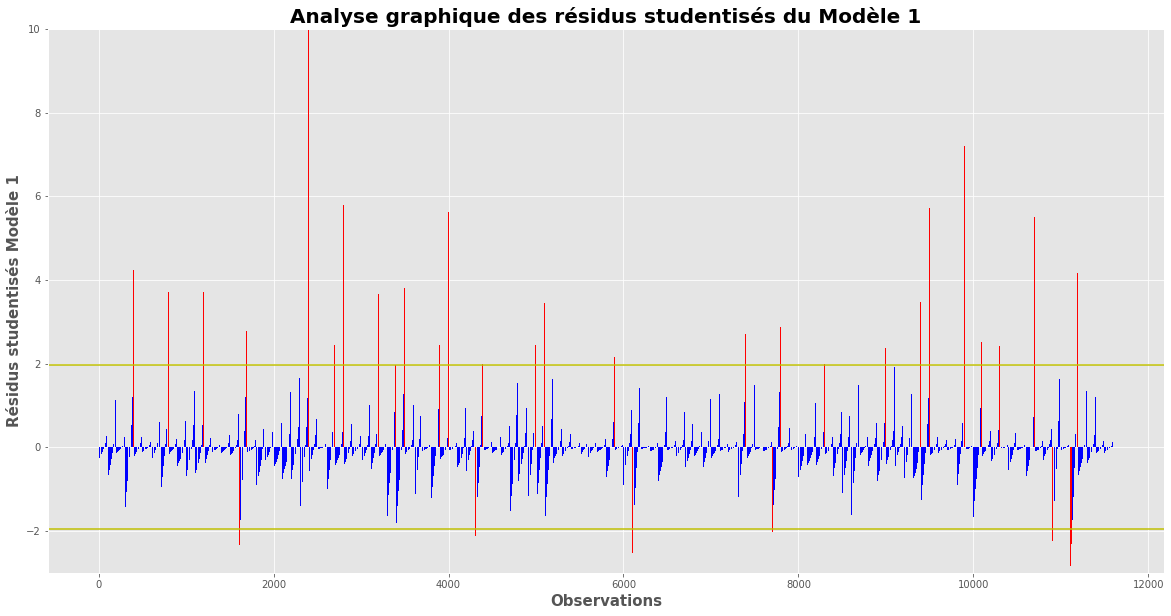

In [ ]:
#Visualisation globale des résidus studentisés du Modèle 1 avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(analyse_rstudent[(analyse_rstudent['rstudent_modele1'] <= seuil_rstudent) & 
                            (analyse_rstudent['rstudent_modele1'] >= -seuil_rstudent)]['country'].index, 
        analyse_rstudent[(analyse_rstudent['rstudent_modele1'] <= seuil_rstudent) &
                            (analyse_rstudent['rstudent_modele1'] >= -seuil_rstudent)]['rstudent_modele1'], color='b')

plt.bar(analyse_rstudent[analyse_rstudent['rstudent_modele1'] > seuil_rstudent]['country'].index, 
        analyse_rstudent[analyse_rstudent['rstudent_modele1'] > seuil_rstudent]['rstudent_modele1'], color='r')
plt.bar(analyse_rstudent[analyse_rstudent['rstudent_modele1'] < -seuil_rstudent]['country'].index, 
        analyse_rstudent[analyse_rstudent['rstudent_modele1'] < -seuil_rstudent]['rstudent_modele1'], color='r')


plt.axhline(y=seuil_rstudent, color='y', linestyle='-')
plt.axhline(y=-seuil_rstudent, color='y', linestyle='-')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Résidus studentisés Modèle 1', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des résidus studentisés du Modèle 1', fontsize=20, fontweight='bold')

plt.ylim(-3, 10)
plt.savefig('residus_studentises_modele1.jpg')
plt.show()

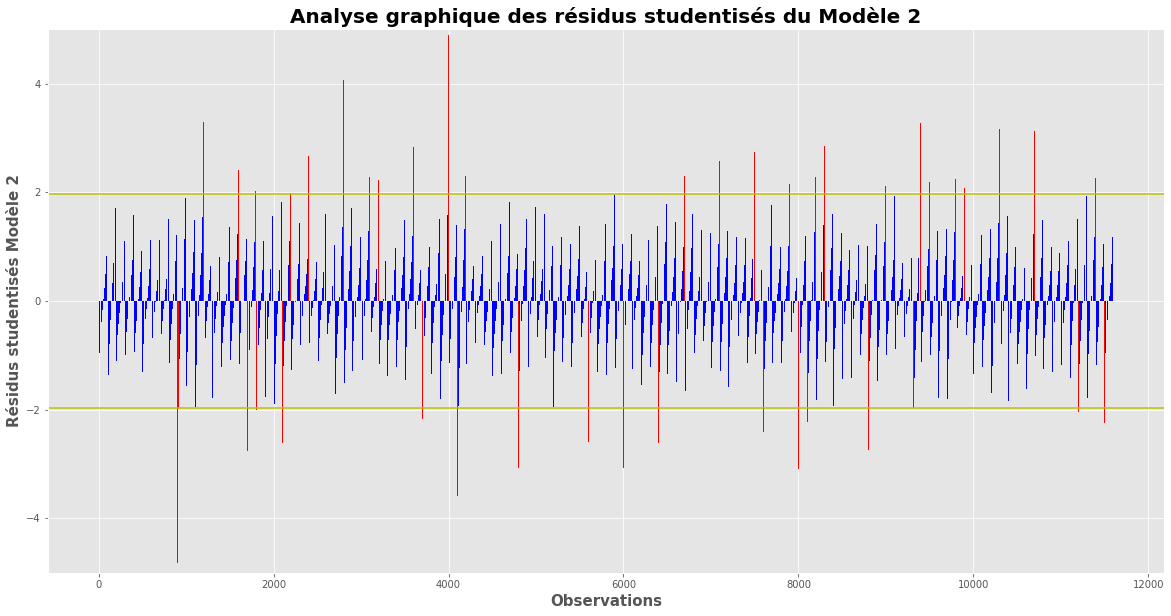

In [ ]:
#Visualisation globale des résidus studentisés du Modèle 2 avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(analyse_rstudent[(analyse_rstudent['rstudent_modele2'] <= seuil_rstudent) & 
                            (analyse_rstudent['rstudent_modele2'] >= -seuil_rstudent)]['country'].index, 
        analyse_rstudent[(analyse_rstudent['rstudent_modele2'] <= seuil_rstudent) &
                            (analyse_rstudent['rstudent_modele2'] >= -seuil_rstudent)]['rstudent_modele2'], color='b')

plt.bar(analyse_rstudent[analyse_rstudent['rstudent_modele2'] > seuil_rstudent]['country'].index, 
        analyse_rstudent[analyse_rstudent['rstudent_modele2'] > seuil_rstudent]['rstudent_modele2'], color='r')
plt.bar(analyse_rstudent[analyse_rstudent['rstudent_modele2'] < -seuil_rstudent]['country'].index, 
        analyse_rstudent[analyse_rstudent['rstudent_modele2'] < -seuil_rstudent]['rstudent_modele2'], color='r')

plt.axhline(y=seuil_rstudent, color='y', linestyle='-')
plt.axhline(y=-seuil_rstudent, color='y', linestyle='-')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Résidus studentisés Modèle 2', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des résidus studentisés du Modèle 2', fontsize=20, fontweight='bold')

plt.ylim(-5, 5)
plt.savefig('residus_studentises_model2.jpg')
plt.show()

**L'approche comparative visuelle n'apporte pas de conclusion significative. Il y a forcément des résidus hors seuil, mais à partir des graphiques l'analyse s'arrête là. Voyons en pourcentage ce que peut représenter ces observations plus influentes que les autres.**

In [ ]:
#Comparaison du nombre de valeurs influentes sur les deux modèles
print(str(len(analyse_rstudent[(analyse_rstudent['rstudent_modele1'] > seuil_rstudent) | 
                 (analyse_rstudent['rstudent_modele1'] < -seuil_rstudent)])), 
                 'Valeurs influentes dans le Modèle 1 (sans log)')

print(str(len(analyse_rstudent[(analyse_rstudent['rstudent_modele2'] > seuil_rstudent) | 
                 (analyse_rstudent['rstudent_modele2'] < -seuil_rstudent)])), 
                 'Valeurs influentes dans le Modèle 2 (avec log)')

410 Valeurs influentes dans le Modèle 1 (sans log)
636 Valeurs influentes dans le Modèle 2 (avec log)


In [ ]:
#Pourcentage des observations les plus influentes (hors seuil)
print("Modèle 1: " + str((round(410 / len(analyse_rstudent['rstudent_modele1'])*100, 2))) + "%")
print("Modèle 2 (avec log): " + str((round(635 / len(analyse_rstudent['rstudent_modele2'])*100, 2))) + "%")

Modèle 1: 3.53%
Modèle 2 (avec log): 5.47%


**Les deux modèles proposés présentent entre 3 et 5% de résidus**, celà doit-être combiné avec les valeurs influentes trouvées avec le critère des leviers. 

**Le Modèle 2 avec logarithme reste le favori,** **la variance est certe mieux expliquée, mais désormais nous avons une idée plus précises des pays influents via les leviers, c'est-à-dire environ 4% sur le premier modèle, mais également une idée de la part des observations dont les résidus standardisés approchent les 6%.**

**Analyse de la distance de Cook :**

**Toujours à l'aide de statsmodels la distance de Cook permettra de mieux estimer les influents.**

In [ ]:
influence1 = modele1.get_influence()
influence2 = modele2.get_influence()

cooks_d1 = influence1.cooks_distance[0]
cooks_d2 = influence2.cooks_distance[0]

In [ ]:
#Intégration des distances de Cook dans "analyse"
analyse['dcooks1'] = cooks_d1
analyse['dcooks2'] = cooks_d2

In [ ]:
#Seuil de la distance de Cook est de n-p. 
seuil_dcook = 4/(n-p)

In [ ]:
#Simplification des données propres aux distances de Cook des deux modèles
analyse_dcook = analyse.groupby(['country', 'quantile']).mean().reset_index()

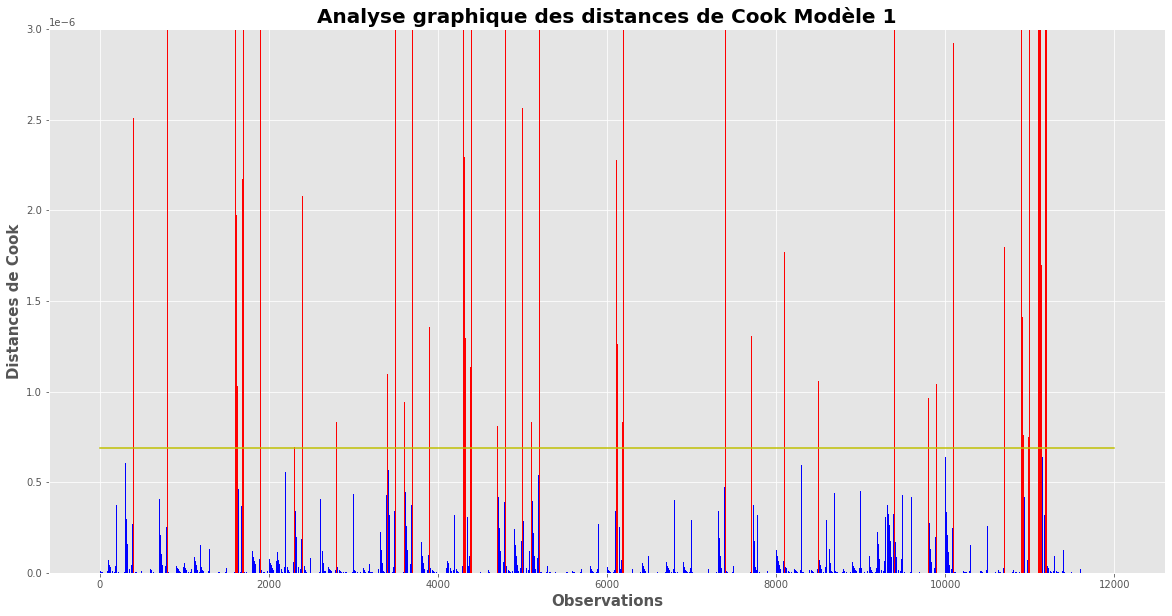

In [ ]:
#Visualisation globale des distances de Cook du Modèle 1 avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(analyse_dcook.loc[analyse_dcook['dcooks1'] < seuil_dcook]['country'].index,
        analyse_dcook.loc[analyse_dcook['dcooks1'] < seuil_dcook]['dcooks1'], color='b')
plt.bar(analyse_dcook.loc[analyse_dcook['dcooks1'] >= seuil_dcook]['country'].index,
        analyse_dcook.loc[analyse_dcook['dcooks1'] >= seuil_dcook]['dcooks1'], color='r')

plt.plot([0, 12000], [seuil_dcook, seuil_dcook], color='y')
plt.ylim(0, 0.000003)

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Distances de Cook', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des distances de Cook Modèle 1', fontsize=20, fontweight='bold')

plt.savefig('dcook_model1.jpg')
plt.show()

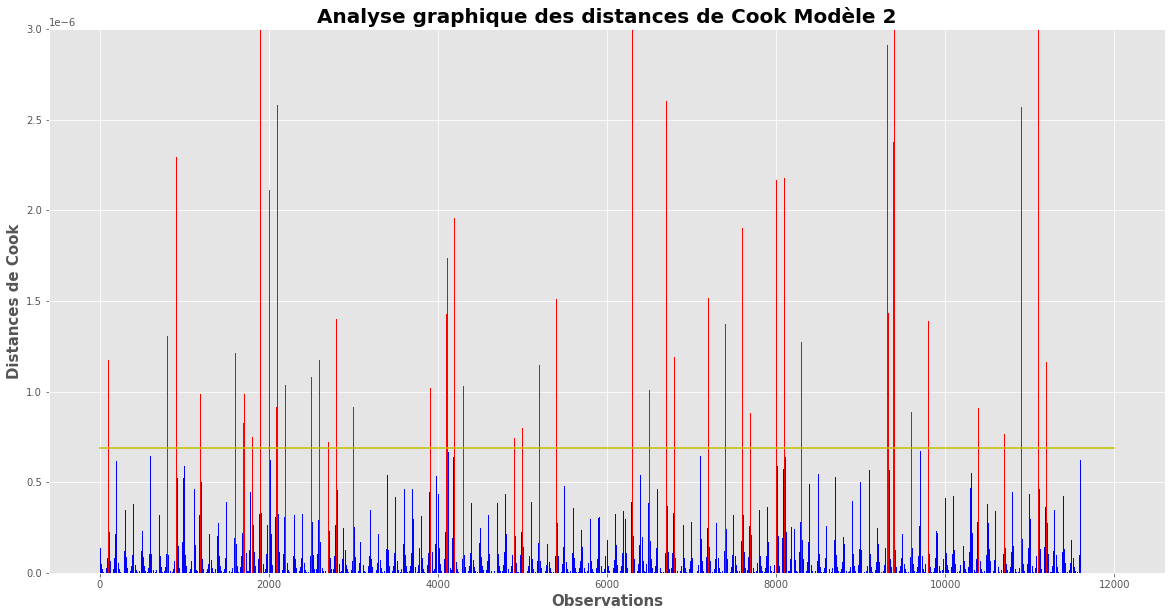

In [ ]:
#Visualisation globale des distances de Cook du Modèle 2 avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(analyse_dcook.loc[analyse_dcook['dcooks2'] < seuil_dcook]['country'].index,
        analyse_dcook.loc[analyse_dcook['dcooks2'] < seuil_dcook]['dcooks2'], color='b')
plt.bar(analyse_dcook.loc[analyse_dcook['dcooks2'] >= seuil_dcook]['country'].index,
        analyse_dcook.loc[analyse_dcook['dcooks2'] >= seuil_dcook]['dcooks2'], color='r')

plt.plot([0, 12000], [seuil_dcook, seuil_dcook], color='y')
plt.ylim(0, 0.000003)

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Distances de Cook', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des distances de Cook Modèle 2', fontsize=20, fontweight='bold')

plt.savefig('dcook_model2.jpg')
plt.show()

In [ ]:
#Nombre d'observations influentes sur le critère de la distance de Cook
print(str(len(analyse_dcook[analyse_dcook['dcooks1'] > seuil_dcook])), 'valeurs influentes dans le Modèle 1')
print(str(len(analyse_dcook[analyse_dcook['dcooks2'] > seuil_dcook])), 'valeurs influentes dans le Modèle 2')

585 valeurs influentes dans le Modèle 1
662 valeurs influentes dans le Modèle 2


In [ ]:
#Pourcentage des observations les plus influentes (hors seuil)
print("Modèle 1: " + str((round(586 / len(analyse_dcook)*100, 2))) + "%")
print("Modèle 2 (avec log): " + str((round(662 / len(analyse_dcook)*100, 2))) + "%")

Modèle 1: 5.05%
Modèle 2 (avec log): 5.71%


**Sur ce critère de distance de Cook, les deux modèles sont plus ou moins identiques, on sait désormais que celà représente 5% des observations.**

On a vu que passer les variables au logarithme renforce la robustesse du modèle, et que les variables n'apportant pas de variance expliquée peuvent au contraire renforcer la colinéarité

**Amélioration du modèle le plus performant en incluant la classe de revenu des parents**

**Le précédent modèle en logarithme (ln) peut sans doute être encore optimisé en incluant une nouvelle variable, ici la classe de revenu des parents.** 

**Le modèle qui ressortira sera normalement plus performant, ce qui nous donnera également la part d'influence que peut avoir ce type de données sur le revenu des individus.**



In [ ]:
#Modèle de Régression linéaire avec ajout d'une variable supplémentaire 
modele2_parents = smf.ols('ln_income ~ gini + ln_y_parent + ln_income_avg', data=df_wid500).fit()
print(modele2_parents.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 5.182e+06
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:32:04   Log-Likelihood:            -6.3237e+06
No. Observations:             5800000   AIC:                         1.265e+07
Df Residuals:                 5799996   BIC:                         1.265e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4732      0.003    162.862

**En ajoutant juste la classe parents, on obtient une variance expliquée de 72% égale à celle obtenue plus tôt sans cette variable. Income_mean_ln et gini_ln sont toujours aussi significatives, mais la classe parents obtient une P>|t| de 88%, indiquant une probable absence de significativé de cette variable.**



**Sans logarithme**


In [ ]:
modele2_parents = smf.ols('income ~ gini + ln_y_parent + ln_income_avg', data=df_wid500).fit()
print(modele2_parents.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 1.257e+06
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:32:06   Log-Likelihood:            -5.9847e+07
No. Observations:             5800000   AIC:                         1.197e+08
Df Residuals:                 5799996   BIC:                         1.197e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.062e+04     29.575  -1035.458

**Sans logarithme, la variance expliquée est legerement faible que la même précédemment obtenue, qu'on ajoute c_i_parent ou non. L'indice de Gini garde la même absence de significativité, comme c_i_parent.

**Cette fois encore, le modèle avec les échelles logaritmiques est meilleur sur tous les indicateurs. Nous allons donc considérer ce dernier modèle ln.**

Pourcentage de variance expliquée par ce modèle

**Sur ce dernier modèle, le pourcentage de variance expliqué est de 72.4 %, ce qui en fait, à priori, le meilleur modèle pour cette analyse.** 

**Pourcentage de variance expliquée par ce modèle**


L'équation d'analyse de variance pour ce modèle est la suivante : 
Pour obtenir ces indicateurs, nous allons afficher la table d'analyse de variances avec Statsmodels, puis calculer les 
 
 (qui correspondent également au R²) : 

In [ ]:
anova_table_global_ln = sm.stats.anova_lm(modele2_parents, typ=2)
anova_table_global_ln["eta_sq"] = anova_table_global_ln[:-1]['sum_sq']/sum(anova_table_global_ln['sum_sq'])
anova_table_global_ln

,sum_sq,df,F,PR(>F),eta_sq
gini,3.013457e+12,1.0,5.611223e+04,0.000000,6.146854e-03
ln_y_parent,1.253714e+08,1.0,2.334485e+00,0.126537,2.557328e-07
ln_income_avg,1.757466e+14,1.0,3.272499e+06,0.000000,3.584882e-01
Residual,3.114836e+14,5799996.0,NaN,NaN,NaN


In [ ]:
var_exp_pays_ln_y_parent = round(sum(anova_table_global_ln[0:-1]["eta_sq"])*100,2)
print("Le pourcentage de la variance expliquée par le pays de naissance et la classe des parents est donc de :",var_exp_pays_ln_y_parent,"%")

Le pourcentage de la variance expliquée par le pays de naissance et la classe des parents est donc de : 36.46 %


In [ ]:
var_exp_model_2 = round((modele2_parents.ess / modele2_parents.centered_tss)*100,2)
var_exp_autres_2 = round(var_exp_model_2 - var_exp_pays_ln_y_parent,2)
print("Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de :",var_exp_autres_2,"%")

Le pourcentage de la variance expliquée par les autres facteurs non considérés est donc de : 2.93 %


In [ ]:
#Variance totale SCT
modele2_parents.centered_tss

513948083183559.3

In [ ]:
#Variance expliquée SCE
modele2_parents.ess

202464491615516.62

In [ ]:
#Variance résiduelle SCR
modele2_parents.ssr

311483591568042.7

** Tests sur ce dernier modèle**


In [ ]:
#Paramètres nécessaires au lancement du diagnostic
alpha = .05        #test niveau 5%
n = len(df_wid500) #nombre d'individus de l'échantillon
p = 4              #nombre de variables

#Nouveau dataframe d'étude du modèle 
diagnostic = df_wid500.copy()
diagnostic.head()

,ln_y_parent,residus,country_code,country,quantile,population,income,income_avg,gini,pj,ln_income,ln_income_avg
0,0.433980,-1.778073,ALB,Albania,1,3002678.0,728.89795,2994.829902,0.3,0.815874,6.591534,8.004643
1,-0.936572,0.358816,ALB,Albania,2,3002678.0,916.66235,2994.829902,0.3,0.815874,6.820739,8.004643
2,0.594741,0.148855,ALB,Albania,3,3002678.0,1010.91600,2994.829902,0.3,0.815874,6.918612,8.004643
3,-0.770170,0.312035,ALB,Albania,4,3002678.0,1086.90780,2994.829902,0.3,0.815874,6.991092,8.004643
4,0.024164,1.833999,ALB,Albania,5,3002678.0,1132.69970,2994.829902,0.3,0.815874,7.032359,8.004643


In [ ]:
#Création de la variable levier
diagnostic['levier'] = modele2_parents.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

In [ ]:
#Agrégation des données selon leurs pays, vision simplifiée du couple pays/levier
#Simplification du dataframe pour une visualisation et interprétation plus rapide
diagnostic_levier = diagnostic.groupby('country').mean().reset_index()

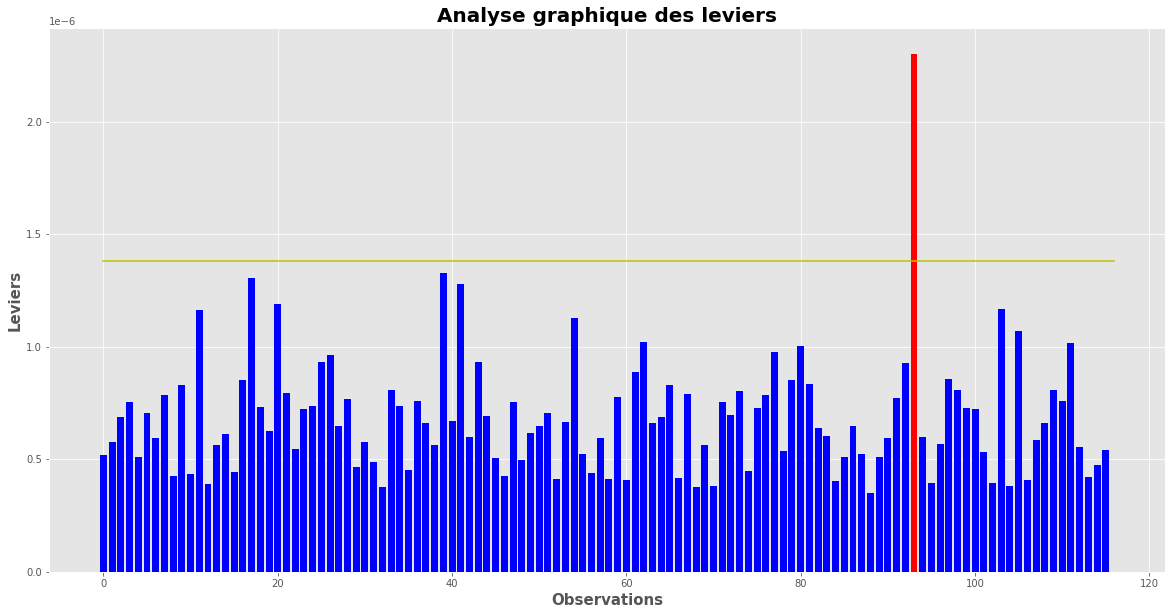

In [ ]:
#Visualisation des leviers par pays avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(diagnostic_levier[diagnostic_levier['levier'] <= seuil_levier]['country'].index,
        diagnostic_levier[diagnostic_levier['levier'] <= seuil_levier]['levier'], color='b')
plt.bar(diagnostic_levier[diagnostic_levier['levier'] > seuil_levier]['country'].index,
        diagnostic_levier[diagnostic_levier['levier'] > seuil_levier]['levier'], color='r')
plt.plot([0, 116], [seuil_levier, seuil_levier], color='y')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Leviers', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des leviers', fontsize=20, fontweight='bold')

plt.savefig('leviers_last_model.jpg')
plt.show()

In [ ]:
#Identification du pays outlier sur le critère des leviers
diagnostic_levier[diagnostic_levier['levier'] > seuil_levier]['country']

93    South Africa
Name: country, dtype: object

Ce n'est pas surprenant, il faut noter qu'en première partie de l'étude, dans la visualisation des distributions de nos variables, ce pays avait été identifié comme tel car son coefficient de Gini était bien trop élevé par rapport aux autres pays...

**Analyse des résidus studentisés**

In [ ]:
#Intégration de la variable liée aux résidus
diagnostic['rstudent'] = modele2_parents.get_influence().resid_studentized_internal

seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [ ]:
#Agrégation des données selon leurs pays, vision simplifiée du couple pays-individu/rstudent
#Simplification du dataframe pour une visualisation et interprétation plus rapide
diagnostic_rstudent = diagnostic.groupby(['country', 'quantile']).mean().reset_index()

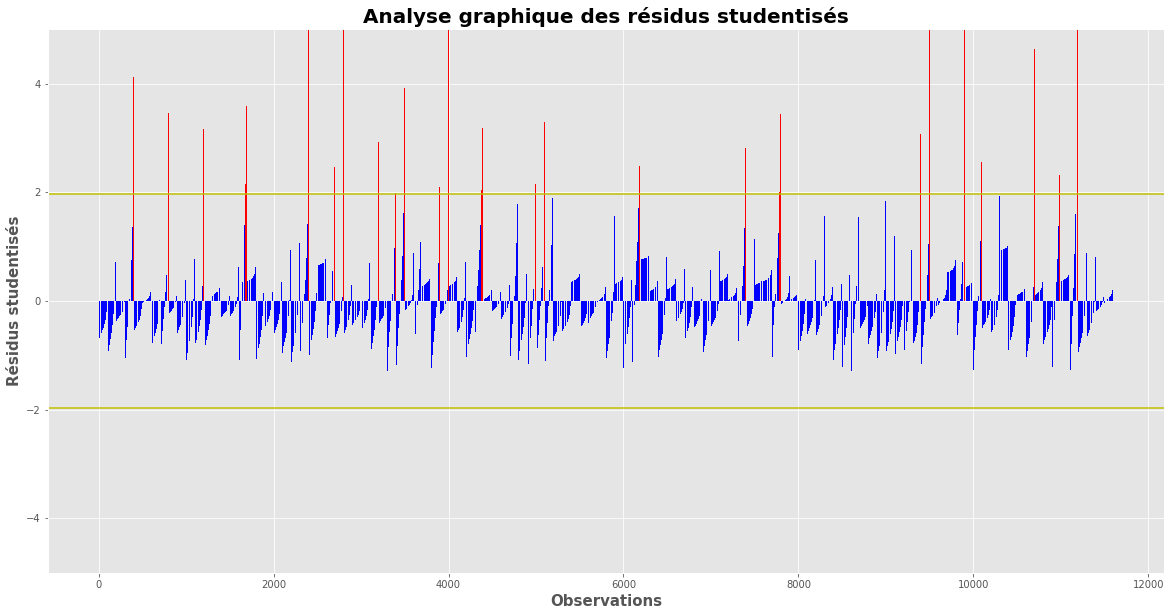

In [ ]:
#Visualisation globale des résidus studentisés avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(diagnostic_rstudent[(diagnostic_rstudent['rstudent'] <= seuil_rstudent) & 
                            (diagnostic_rstudent['rstudent'] >= -seuil_rstudent)]['country'].index, 
        diagnostic_rstudent[(diagnostic_rstudent['rstudent'] <= seuil_rstudent) &
                            (diagnostic_rstudent['rstudent'] >= -seuil_rstudent)]['rstudent'], color='b')

plt.bar(diagnostic_rstudent[diagnostic_rstudent['rstudent'] > seuil_rstudent]['country'].index, 
        diagnostic_rstudent[diagnostic_rstudent['rstudent'] > seuil_rstudent]['rstudent'], color='r')
plt.bar(diagnostic_rstudent[diagnostic_rstudent['rstudent'] < -seuil_rstudent]['country'].index, 
        diagnostic_rstudent[diagnostic_rstudent['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

plt.axhline(y=seuil_rstudent, color='y', linestyle='-')
plt.axhline(y=-seuil_rstudent, color='y', linestyle='-')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Résidus studentisés', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des résidus studentisés', fontsize=20, fontweight='bold')

plt.ylim(-5, 5)
plt.savefig('residus_studentises_last_model.jpg')
plt.show()

In [ ]:
#Pourcentage des observations hors seuil sur le critère des résidus standardisés
print(str(len(diagnostic_rstudent[(diagnostic_rstudent['rstudent'] > seuil_rstudent) | 
                 (diagnostic_rstudent['rstudent'] < -seuil_rstudent)])), 
                 'valeurs influentes dans le Modèle')
print('soit ' + str(round(477/len(diagnostic_rstudent), 2)*100) + '% valeurs plus influentes que les autres')

336 valeurs influentes dans le Modèle
soit 4.0% valeurs plus influentes que les autres


**Analyse de la distance de Cook**

In [ ]:
influence = modele2_parents.get_influence()

cooks_d = influence1.cooks_distance[0]

In [ ]:
#Intégration des distances de Cook dans "diagnostic"
diagnostic['dcooks'] = cooks_d

In [ ]:
#Seuil de la distance de Cook est de n-p. 
seuil_dcook = 4/(n-p)

In [ ]:
#Simplification des données propres à l'analyse de la distance de Cook
diagnostic_dcook = diagnostic.groupby(['country', 'quantile']).mean().reset_index()

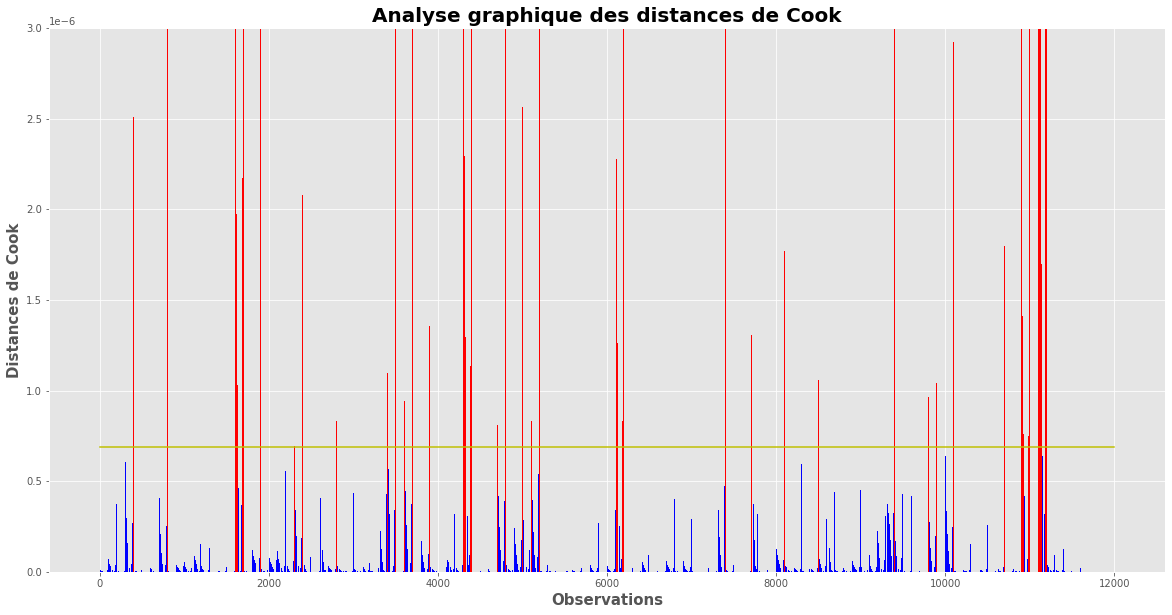

In [ ]:
#Visualisation globale des distances de Cook avec représentation du seuil
plt.figure(figsize=(20,10))

plt.bar(diagnostic_dcook[diagnostic_dcook['dcooks'] < seuil_dcook]['country'].index,
        diagnostic_dcook[diagnostic_dcook['dcooks'] < seuil_dcook]['dcooks'], color='b')
plt.bar(diagnostic_dcook[diagnostic_dcook['dcooks'] >= seuil_dcook]['country'].index,
        diagnostic_dcook[diagnostic_dcook['dcooks'] >= seuil_dcook]['dcooks'], color='r')

plt.plot([0, 12000], [seuil_dcook, seuil_dcook], color='y')
plt.ylim(0, 0.000003)

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('Distances de Cook', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des distances de Cook', fontsize=20, fontweight='bold')

plt.savefig('dcook_last_model.jpg')
plt.show()

In [ ]:
#Pourcentage des observations hors seuil sur le critère de la distance de Cook
print(str(len(diagnostic_dcook[diagnostic_dcook['dcooks'] >= seuil_dcook])) 
      + ' valeurs atypiques sur le critère de d. Cook')
print('soit ' + str(round(586/len(diagnostic_dcook), 2)*100) + '% des valeurs sont plus atypiques selon ce seuil.')

585 valeurs atypiques sur le critère de d. Cook
soit 5.0% des valeurs sont plus atypiques selon ce seuil.


**Test de colinéarité du dernier modèle**


Ci-dessous test de vérification de la colinéarité approchée de nos variables.

In [ ]:
variables = modele2_parents.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0649101051463263, 1.0000000599834318, 1.0649100491303438]

**Aucun problème de colinéarité, en effet nos coefficients sont inférieurs à 10 et même à 5.**

**L’homoscédasticité par un test de Breusch-Pagan**

On peut également tester l’homoscédasticité, la constance de la variance des résidus :



In [ ]:
__, pval, __, f_pval = sms.het_breuschpagan(modele2_parents.resid, modele2_parents.model.exog)
print('p value test Breusch-Pagan:', pval)

p value test Breusch-Pagan: 0.0


**Rejet de l'hypothèse H0 (les variances sont constantes), il y a hétéroscédasticité des residus.**
Ceci étant, le modèle de regression linéaire multiple est robuste pour les grands échantillons, ce qui est le cas dans notre contexte. Le modèle est capable de supporter des écarts important aux hypothèses homoscédastique et gaussienne.

**Réponse à la dernière question sur l'indice de Gini**
 En observant le coefficient de régression associé à l’indice de Gini, peut-on affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu’il n’en défavorise ?

Comme nous l'avons déjà vu, plus l'indice de Gini est élevé, plus la répartition du pays est inégalitaire. De ce fait, une petite proportion de la population détient la plus grosse part des richesses. Les écarts dans les salaires sont très élevés avec des revenus par individus faible.

L'exemple du précédent modèle est révélateur, on peut comprendre ce lien par le coefficient négatif au sein du modèle.


